In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sns
import utils
import numpy as np

plt.style.use("ggplot")

## Chemistry data pre-processing
This notebook takes raw data extracted from NIVA database and  

## 0. Inputs

In [2]:
dataset_path = '../../data/river/water_chem/raw_niva/dremmen_glomma_numed_wc_2024.csv'
output_path = '../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_2024_cleaned.csv'

# variables of interest
variables = ['DOC_mg/L C', 'DOC_mg/l', 'Farge_mg Pt/l', 'NH4-N_µg/l', 'TOTN_EF_usikker_µg/l',
             'NO3+NO2-N_µg/l', 'NO3-N_µg/l', 'PO4-P_µg/l', 'STS_mg/l', 'SiO2_mg/l', 'Si_mg/l',
             'TOC_mg/l', 'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TOTP_µg/l',
             'TSM_mg/l', 'UV-Abs. 254nm_Abs/cm', 'UV-Abs. 410nm_Abs/cm', 'POC_µg/l C']

## 1. Load data

In [3]:
wc_df = pd.read_csv(dataset_path)
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])
wc_df.keys()

Index(['station_id', 'station_code', 'station_name', 'sample_date', 'depth1',
       'depth2', 'DOC_mg/L C', 'DOC_mg/l', 'Farge_mg Pt/l', 'NH4-N_µg/l',
       'NO3+NO2-N_µg/l', 'NO3-N_µg/l', 'PO4-P_µg/l', 'POC_µg/l C', 'STS_mg/l',
       'SiO2_mg/l', 'Si_mg/l', 'TOC_mg/l', 'TOTN_EF_usikker_µg/l', 'TOTN_µg/l',
       'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TOTP_µg/l', 'TSM_mg/l',
       'UV-Abs. 254nm_Abs/cm', 'UV-Abs. 410nm_Abs/cm'],
      dtype='object')

## 2. Visualize raw data

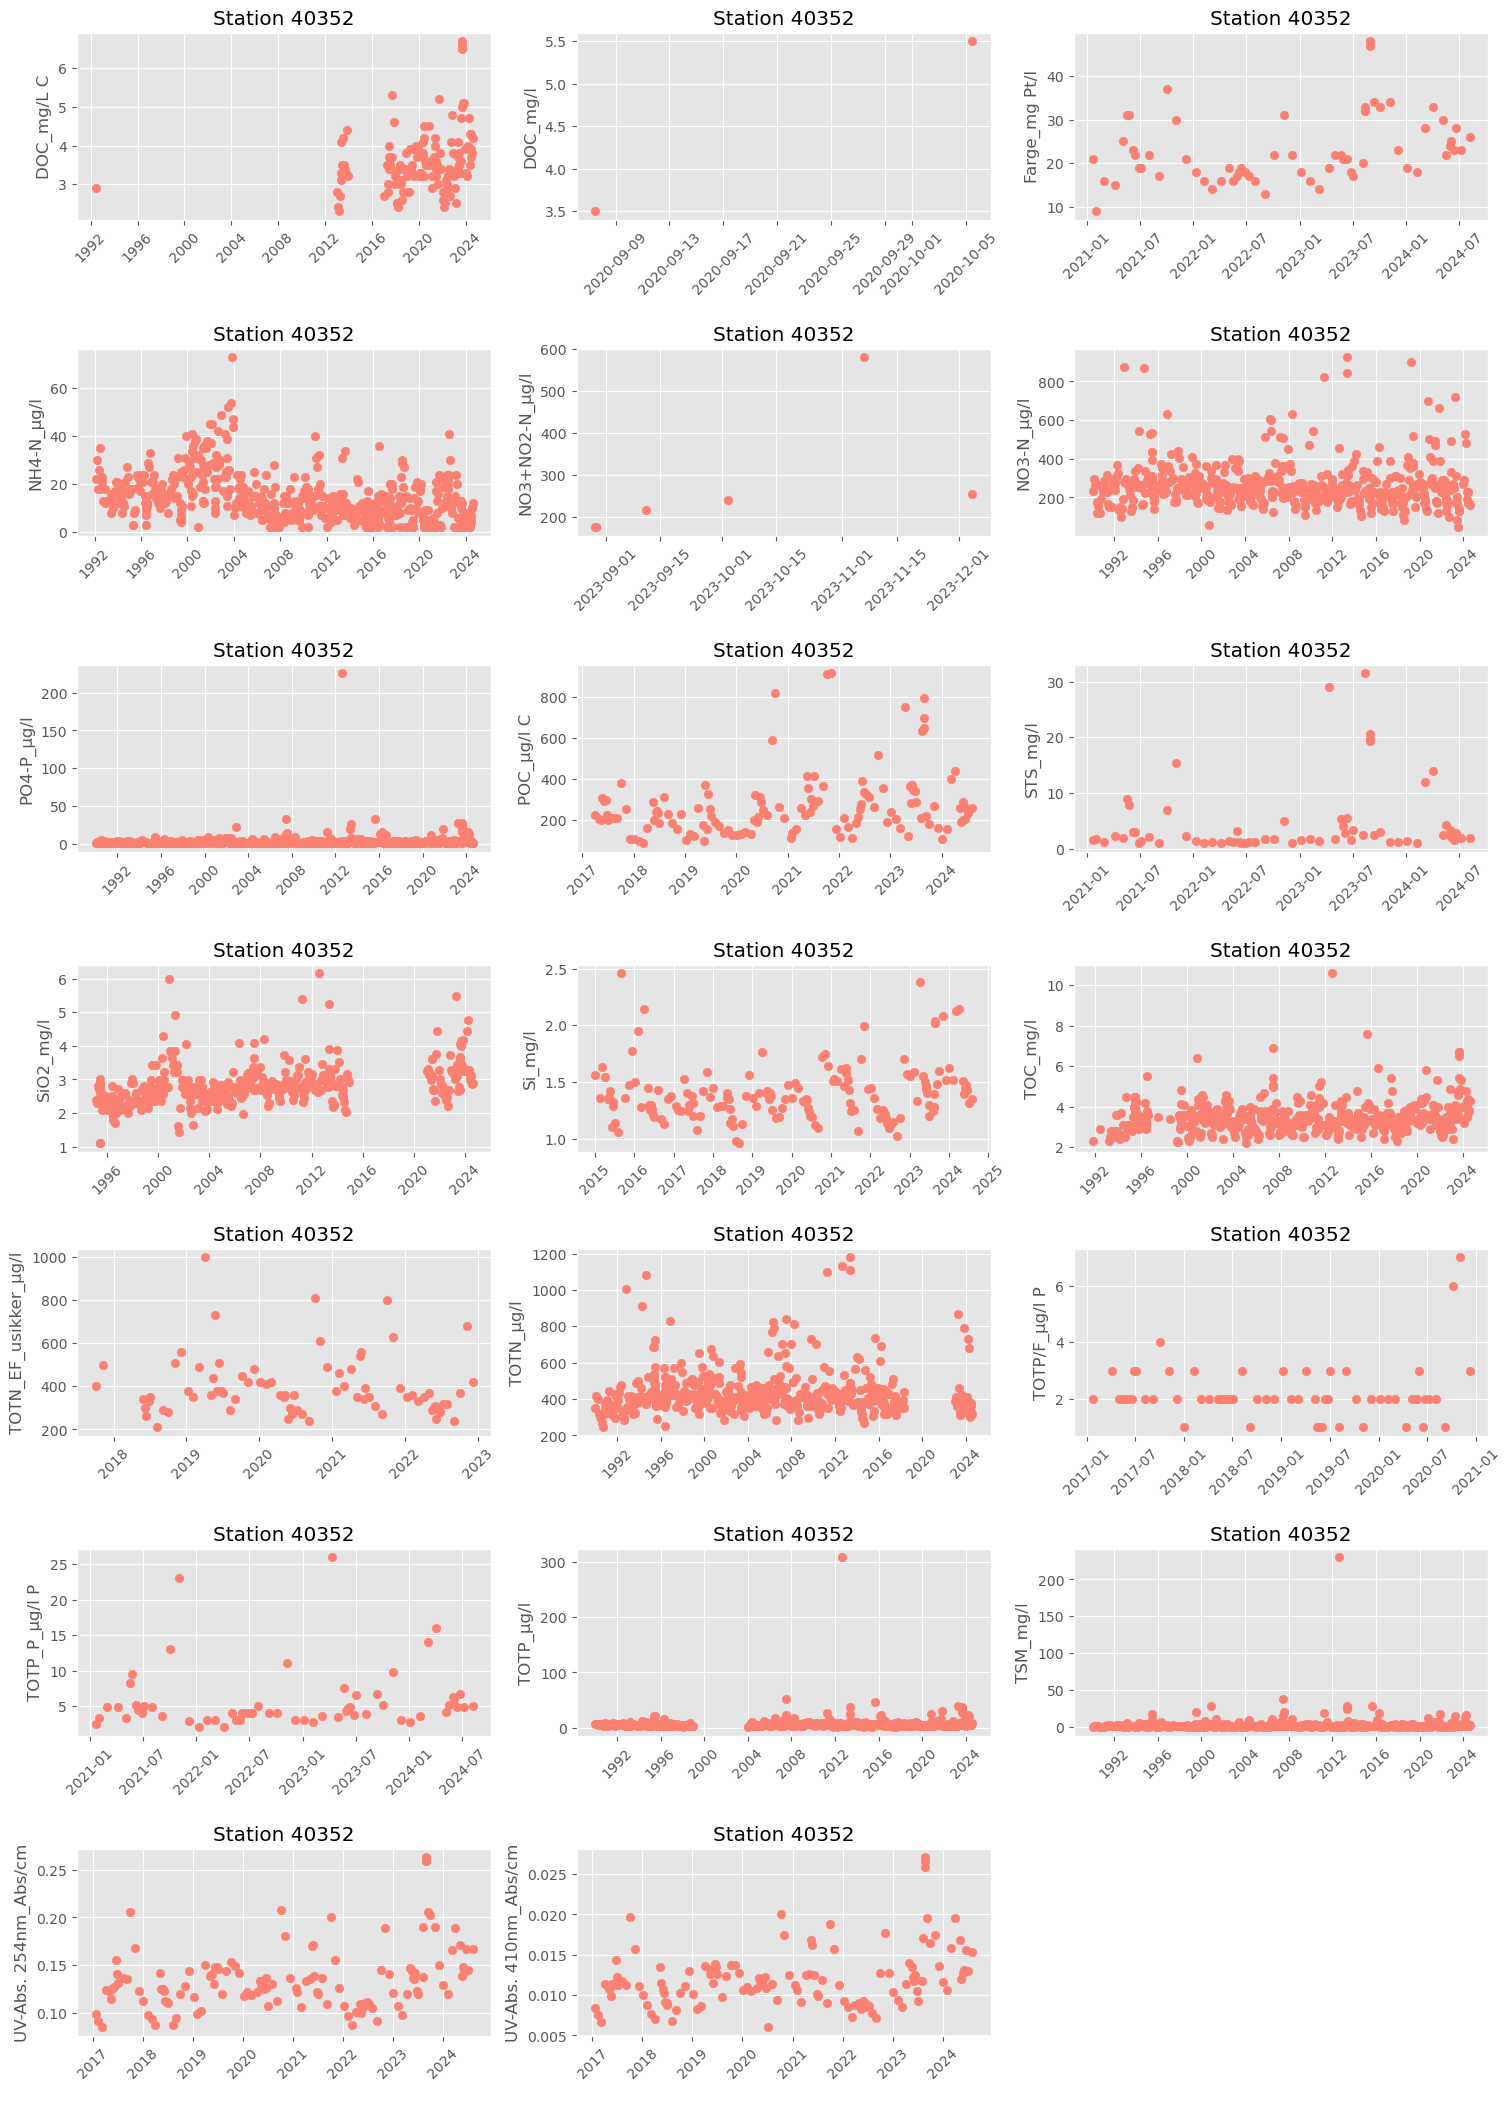

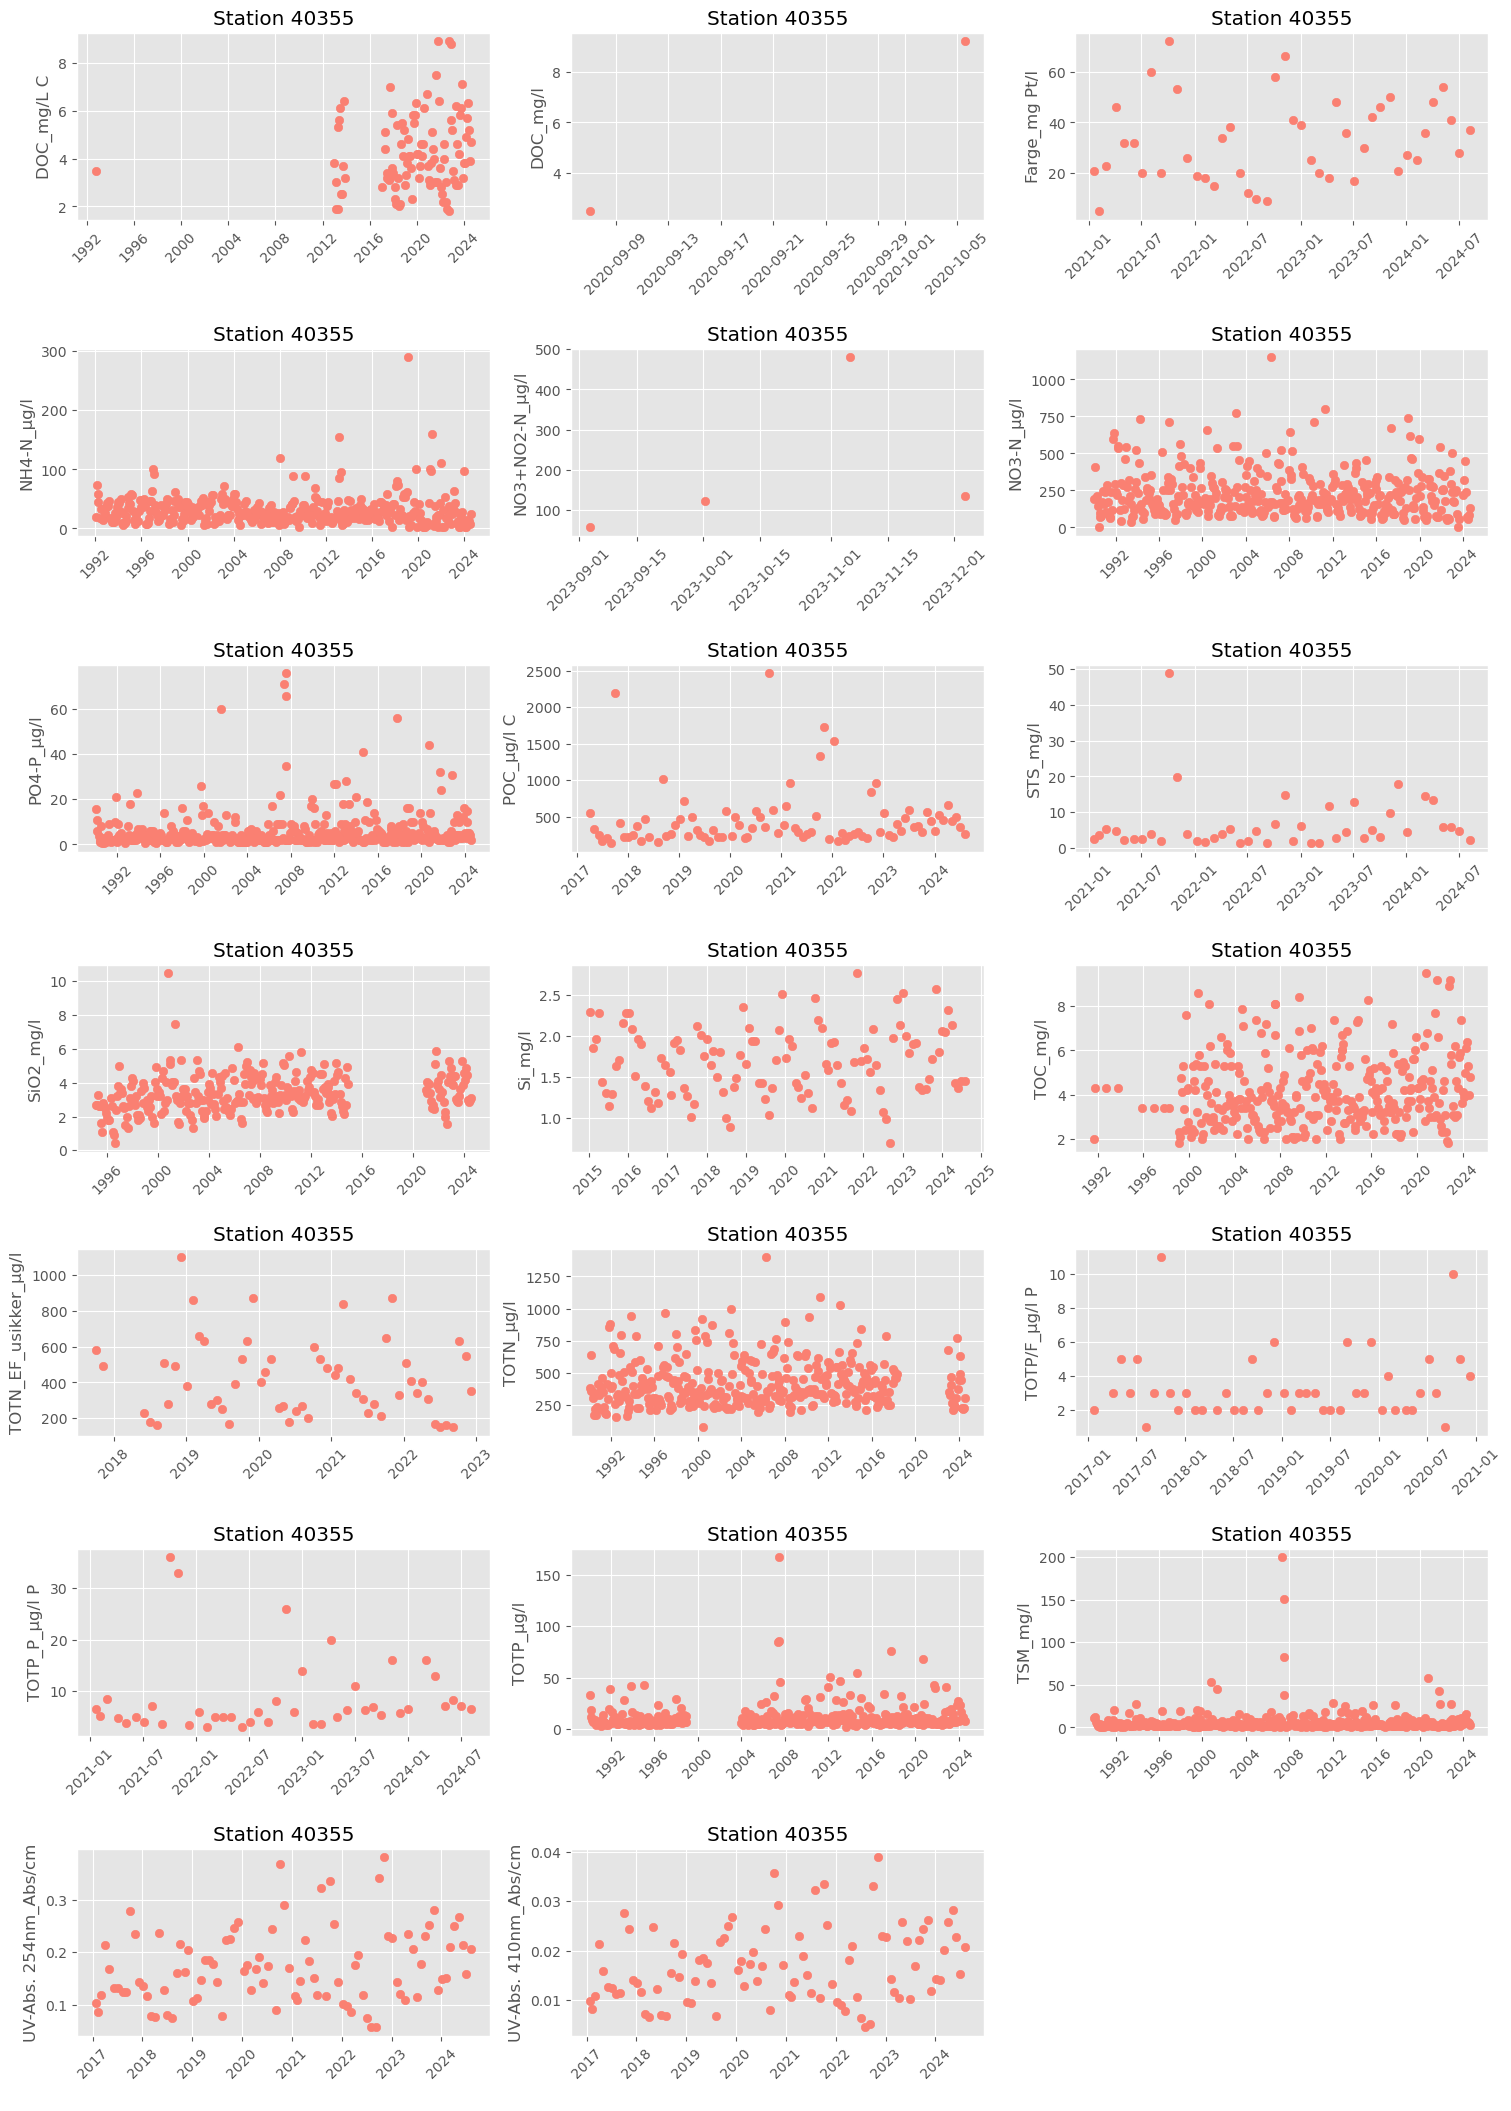

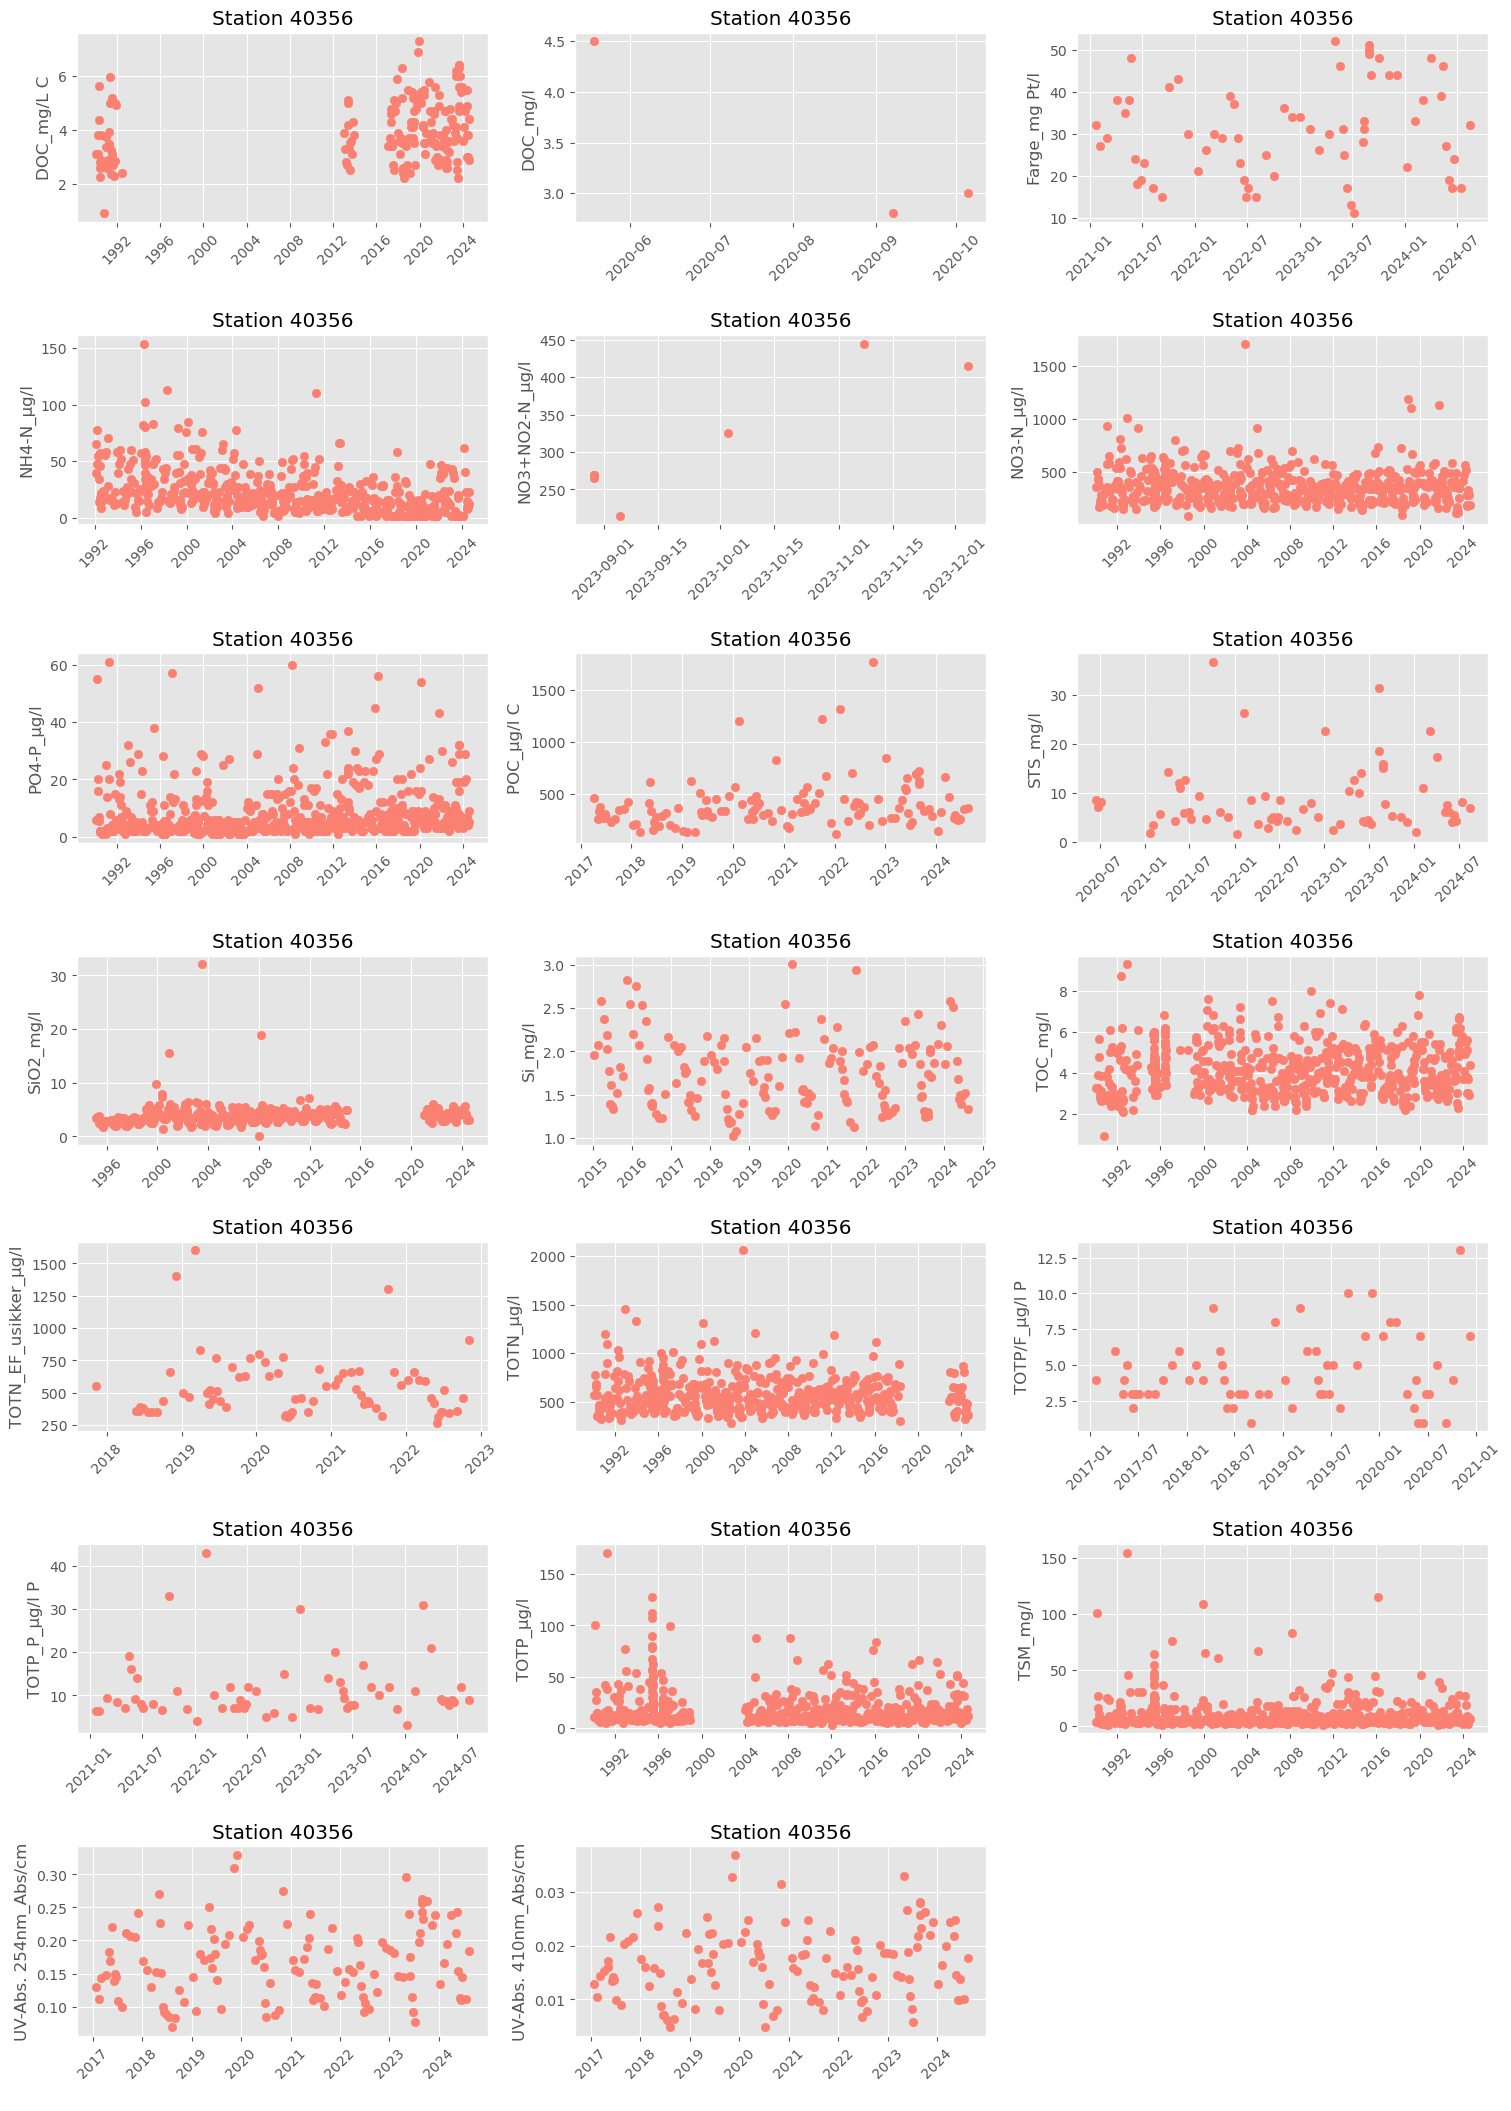

In [4]:
stations = wc_df["station_id"].unique()

num_cols = 3

# Plot
for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    variables = station_df.columns.difference(["station_id", "station_code", "station_name", "sample_date", "depth1", "depth2"])
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

## 3. Preprocessing

#### 3.1 Drop depths and variables with very few data

In [5]:
wc_df = wc_df.drop(columns=['DOC_mg/l', 'NO3+NO2-N_µg/l', 'depth1', 'depth2'])

#### 3.2 Produce continuous TOTN and SiO2 time series 

The following steps have been performed:

* Use of TOTN_EF_usikker for the missing TOTN (combining different monitoring programs).
* Calculate SiO2 from Si. Silicate has been analyzed with different methods since 1990, SiO2 (which is based on a photometric method) and Si (which is based on ICP MS). The methods should give comparable results. The calculation can be made based on the atomic weights. Si: 28.1 g/mol.
O: 16 g/mo & SiO2: 60.1 g/m.
* From Si to SiO2 (mg/l) -->   S  * 2.14


In [6]:
# Combine TOTN_µg/l and TOTN_EF_usikker_µg/l columns
wc_df['TOTN_µg/l'] = wc_df['TOTN_µg/l'].fillna(wc_df['TOTN_EF_usikker_µg/l'])

# Calculate SiO2 from Si
wc_df['SiO2_mg/l_calculated'] = wc_df['Si_mg/l'] * 2.14
wc_df['SiO2_mg/l'] = wc_df['SiO2_mg/l'].fillna(wc_df['SiO2_mg/l_calculated'])

# Drop unnecessary columns 
wc_df = wc_df.drop(columns=['TOTN_EF_usikker_µg/l', 'SiO2_mg/l_calculated', 'Si_mg/l'])

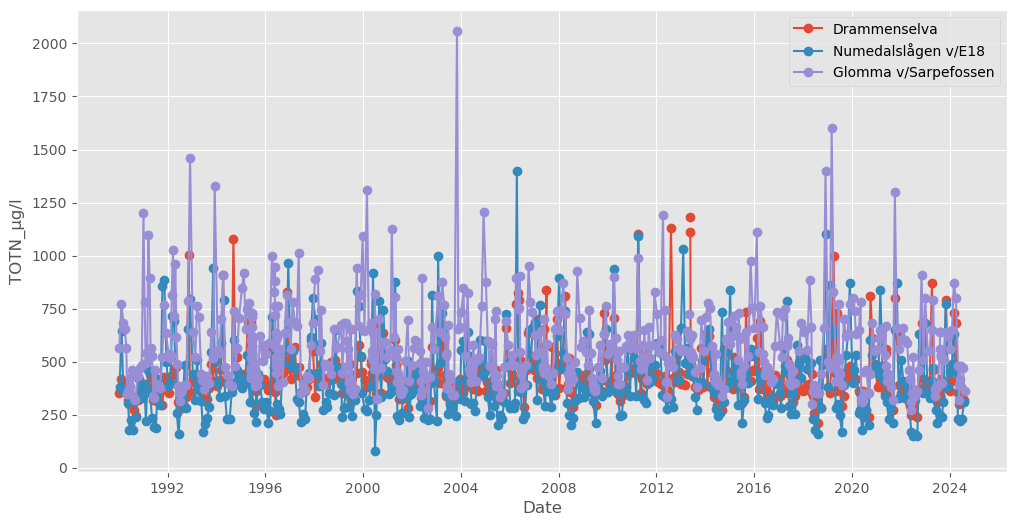

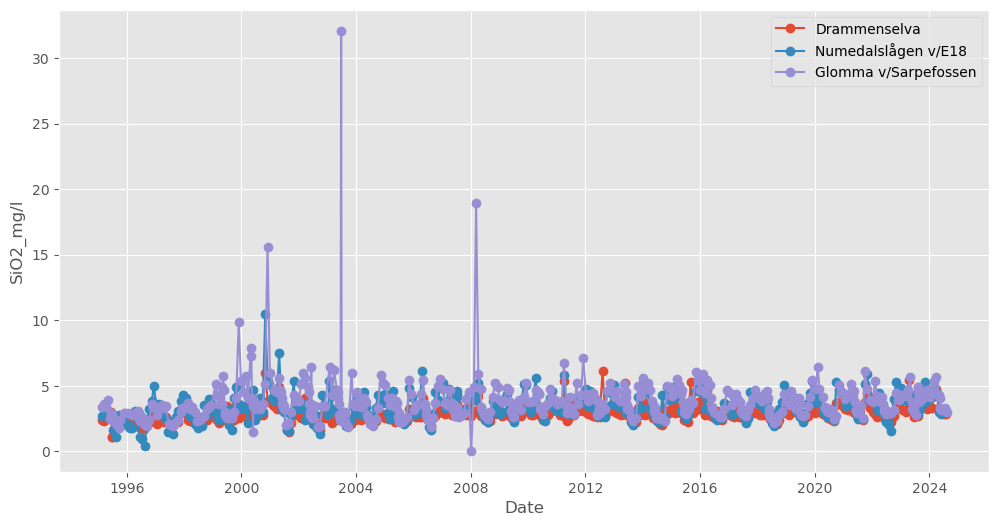

In [7]:
# Visualize outcome of preprocessing
variables = ['TOTN_µg/l', 'SiO2_mg/l']  # List of variables to plot

for variable in variables:  
    plt.figure(figsize=(12, 6)) 
    
    for station in wc_df['station_name'].unique():
        subset = wc_df[wc_df['station_name'] == station]
        plt.plot(subset['sample_date'], subset[variable], label=station, marker='o', linestyle='-')
    
    plt.xlabel('Date')
    plt.ylabel(variable)  
    plt.legend()
    plt.grid(True)
    
    plt.show()

#### 3.3 Compare TSM and STS

The main difference between the methods is that STS uses "regular" glass fiber filters: GF/C (0.45 µm), and the weighing of the filters takes place on a "regular" analytical weight that weighs grams with 4 (or maybe 5) decimal places.

TSM uses nucleopore capillary filters, which have smaller pore size (0.2 µm? - not confirmed with the lab!) than the glass fiber filters. Filters are weighed on a micro-weight, which measures the weight in milligrams with several decimal places.

In principle, TSM values should be higher than STS due to smaller filter pore size.

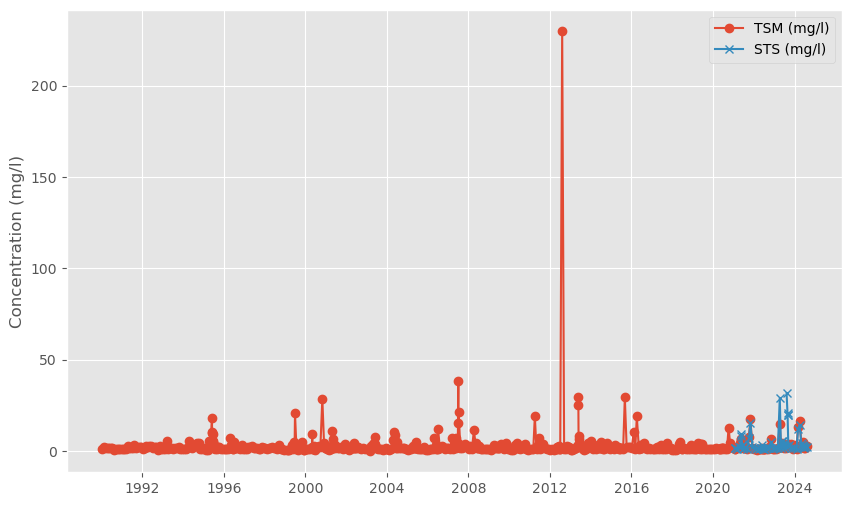

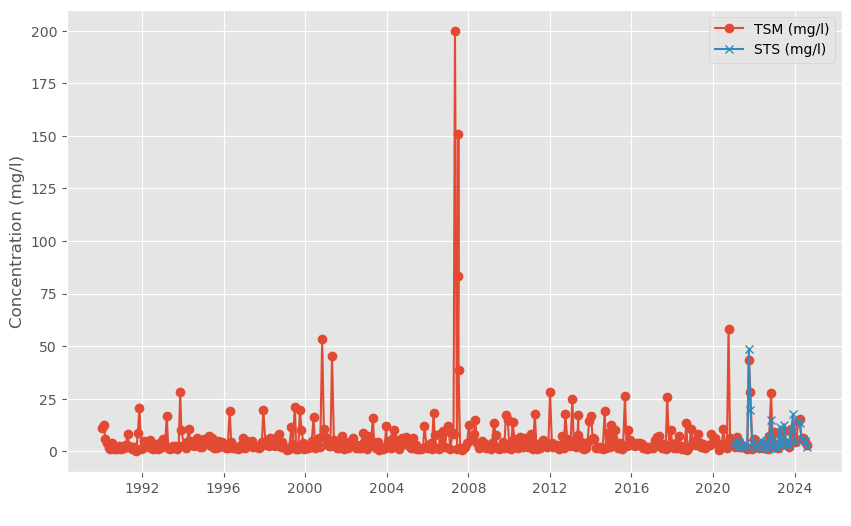

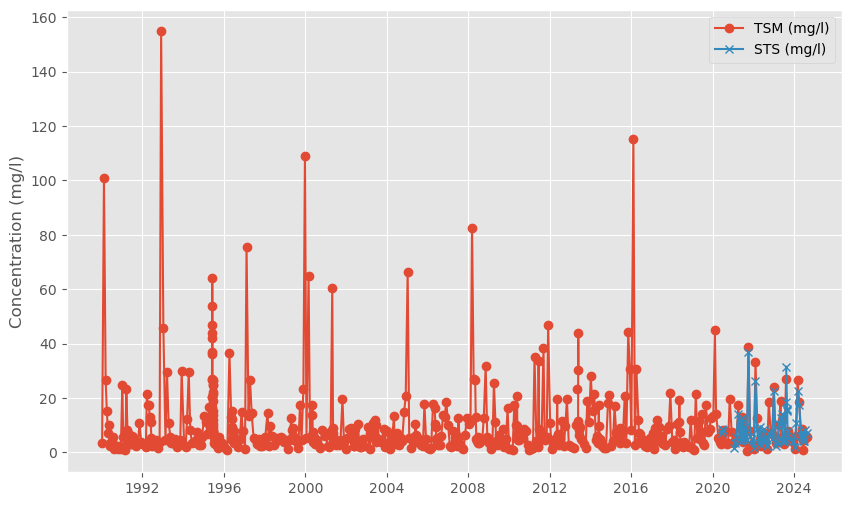

In [8]:
stations = wc_df['station_code'].unique()

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TSM_mg/l'], label='TSM (mg/l)', marker='o')
    plt.plot(station_df['sample_date'], station_df['STS_mg/l'], label='STS (mg/l)', marker='x') 
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

# We can proceed with TSM as we have more data and TSM is more accurate than STS.

Sometimes, STS is slightly higher than TSM, even though we would typically expect the opposite. However, this parameter might be relevant when investigating the Hans event, so I will include it in the final dataset. 

#### 3.4 Compare TOC, DOC and POC 

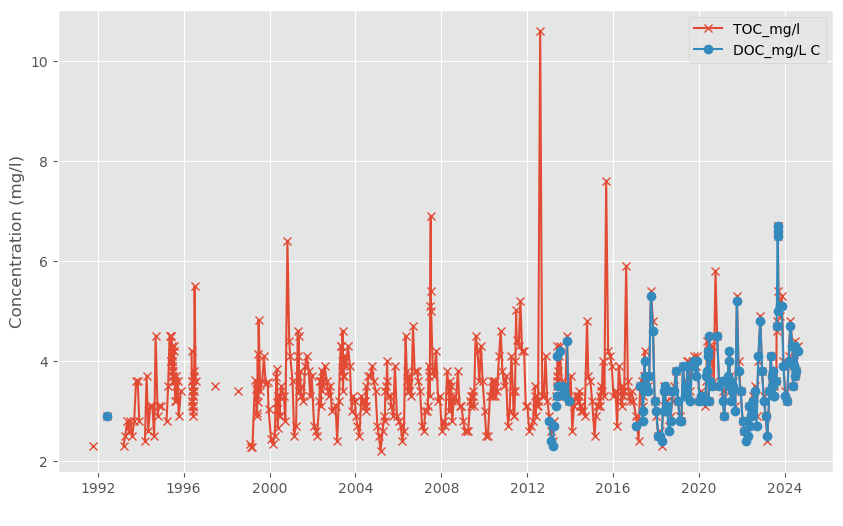

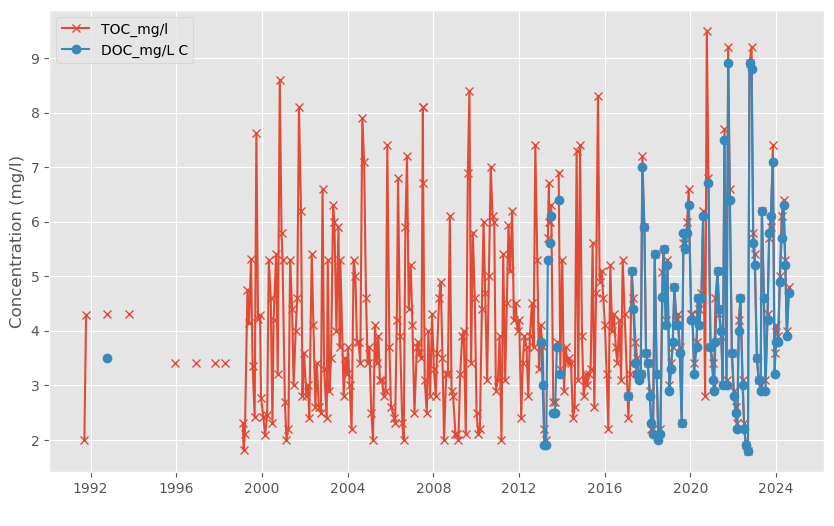

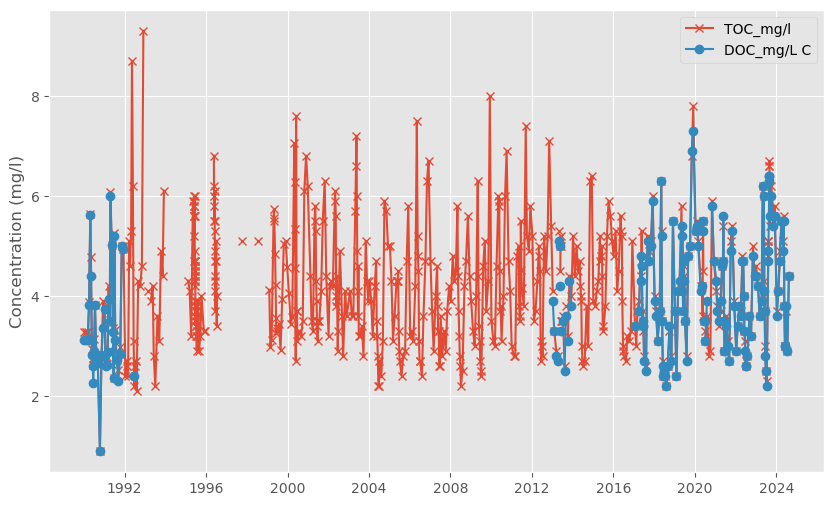

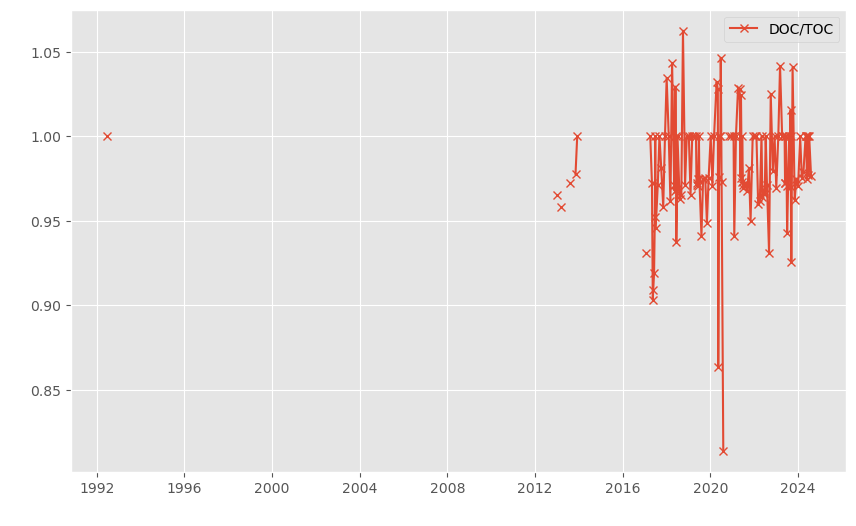

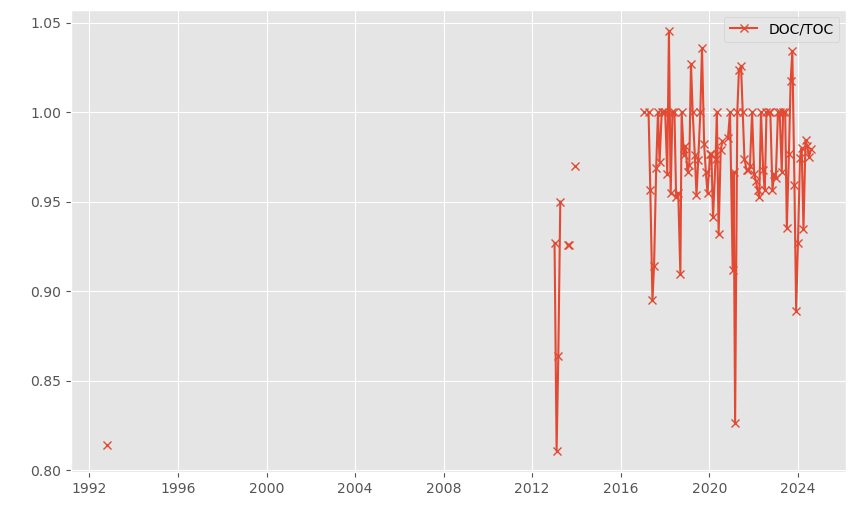

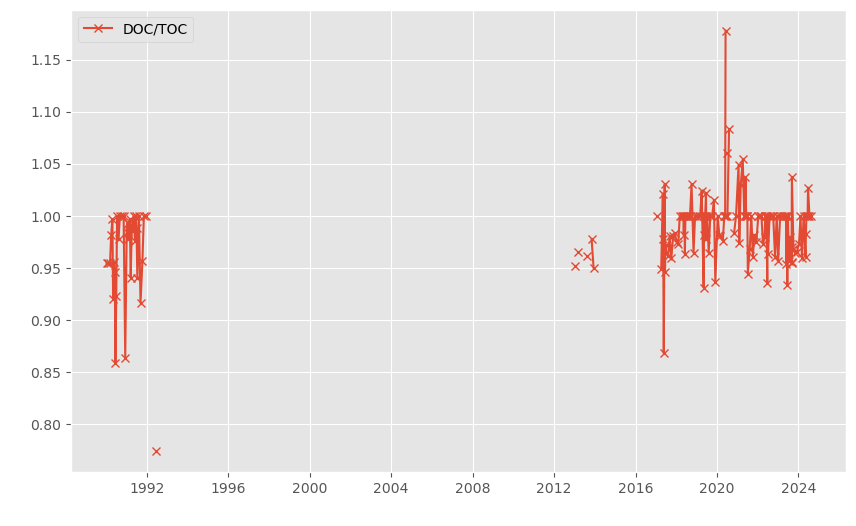

station_code   DOC/TOC
0         DRA1  0.981426
1         GLO1  0.983659
2         NUM1  0.968519

In [9]:
# TOC vs DOC

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

wc_df['DOC/TOC'] = wc_df['DOC_mg/L C'] / wc_df['TOC_mg/l']

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['DOC/TOC'], label='DOC/TOC', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.legend()
    plt.grid(True)
    plt.show()

ratios = wc_df.groupby('station_code')['DOC/TOC'].mean().reset_index()
ratios

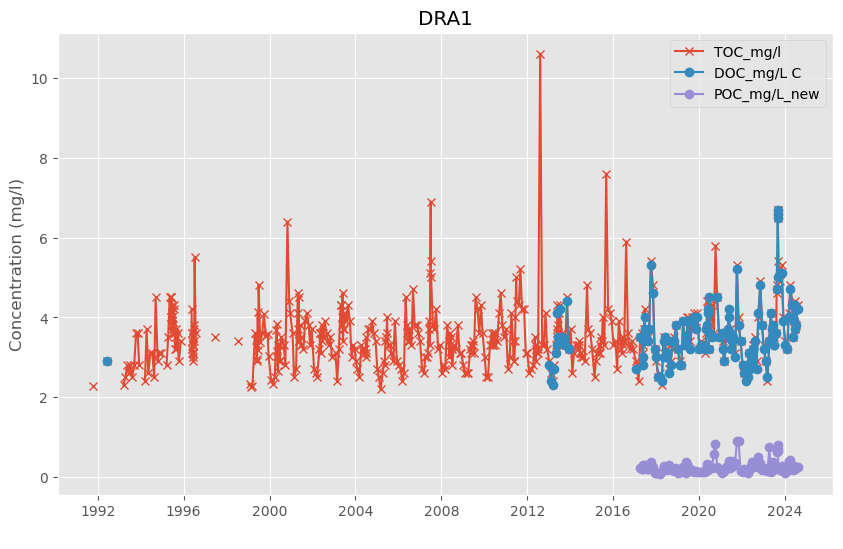

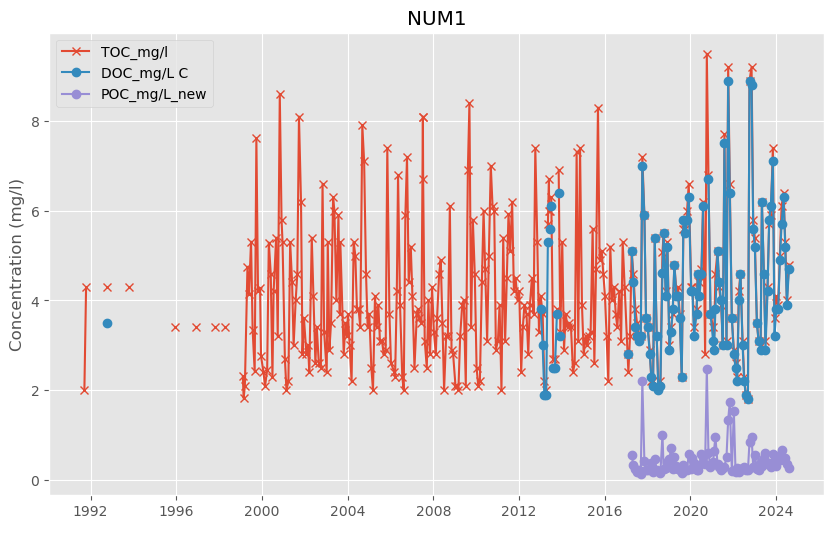

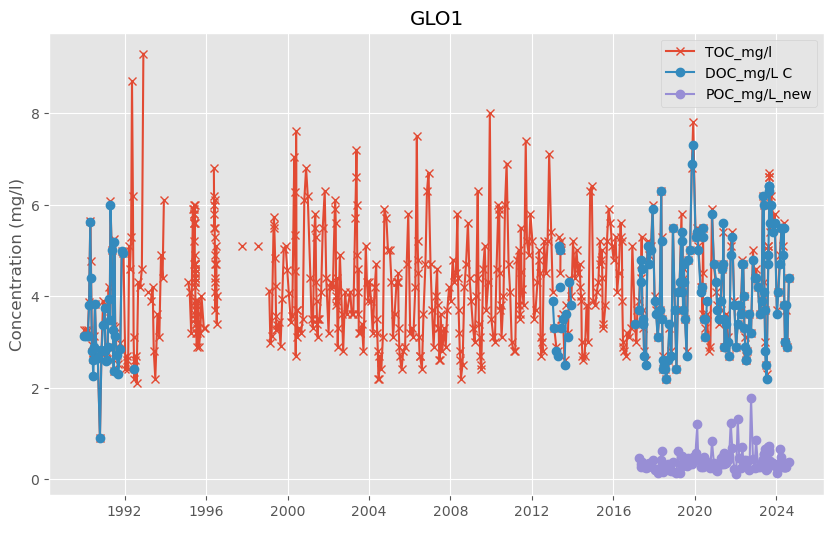

In [10]:
# TOC, DOC and POC (from the dataset)

# Units conversion
wc_df['POC_mg/L_new'] = wc_df['POC_µg/l C'] / 1000

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['POC_mg/L_new'], label='POC_mg/L_new', marker='o')

    plt.title(station)
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

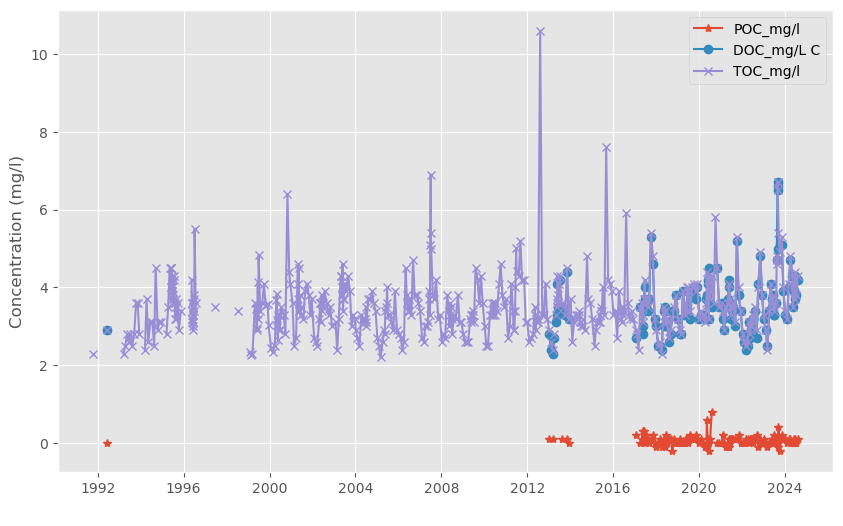

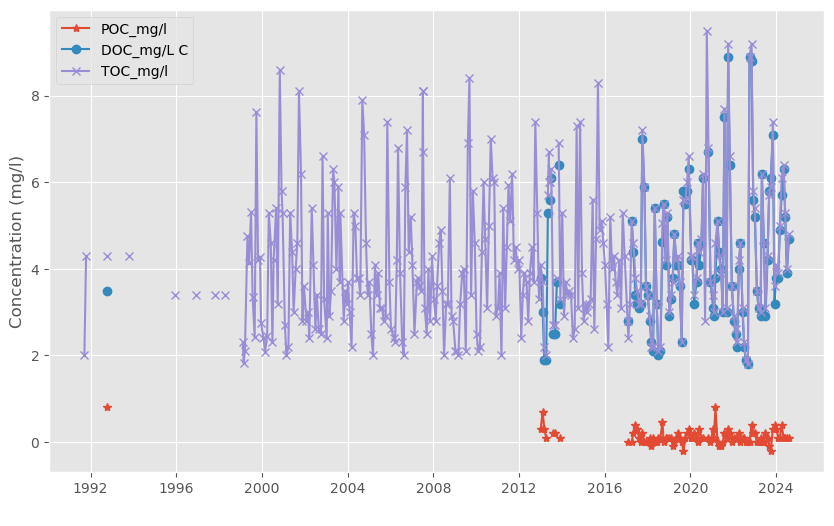

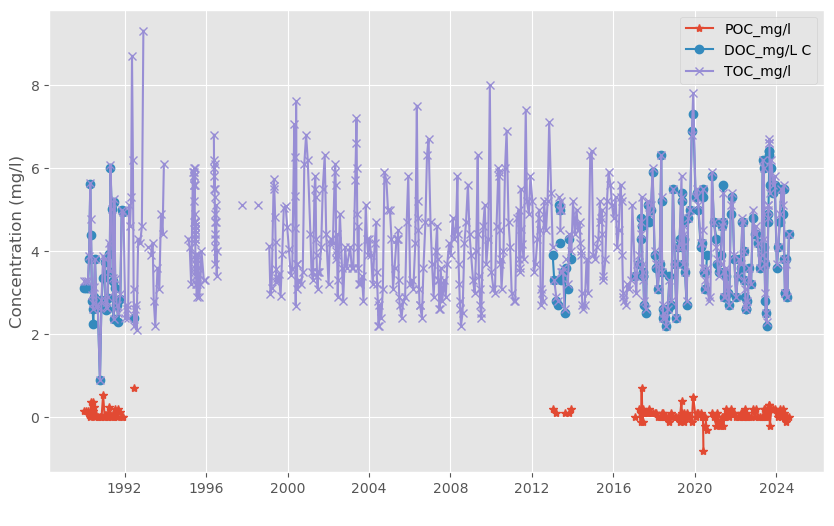

In [11]:
# TOC, DOC and POC (newly computed)
wc_df['POC_mg/l'] = wc_df['TOC_mg/l'] - wc_df['DOC_mg/L C']

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['POC_mg/l'], label='POC_mg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Note:** DOC and TOC values are nearly identical across all three rivers, suggesting that POC is minimal. The average DOC/TOC ratio for each river is near 1. This support the use of TOC as a proxy for DOC, especially since TOC has a longer and more continuous time series.

#### 3.5 Compare TOTP vs TOTP/F

TOTP is the sum of TOTP/F and TOTP_P. When only two of the three variables are available, I compute the missing one accordingly to fill the gaps in the dataset.

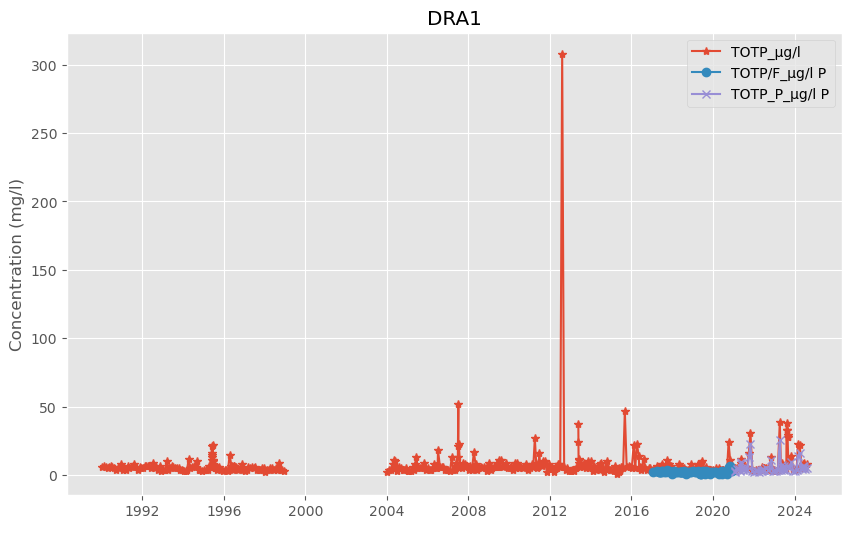

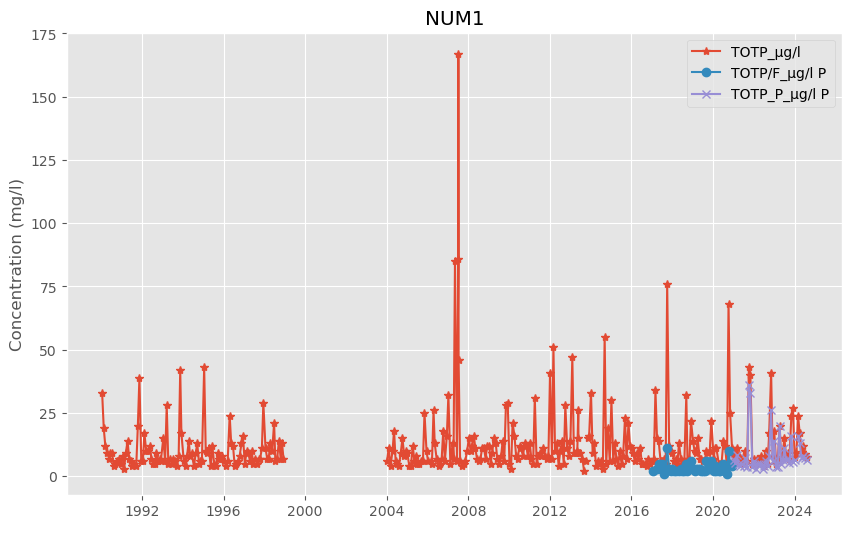

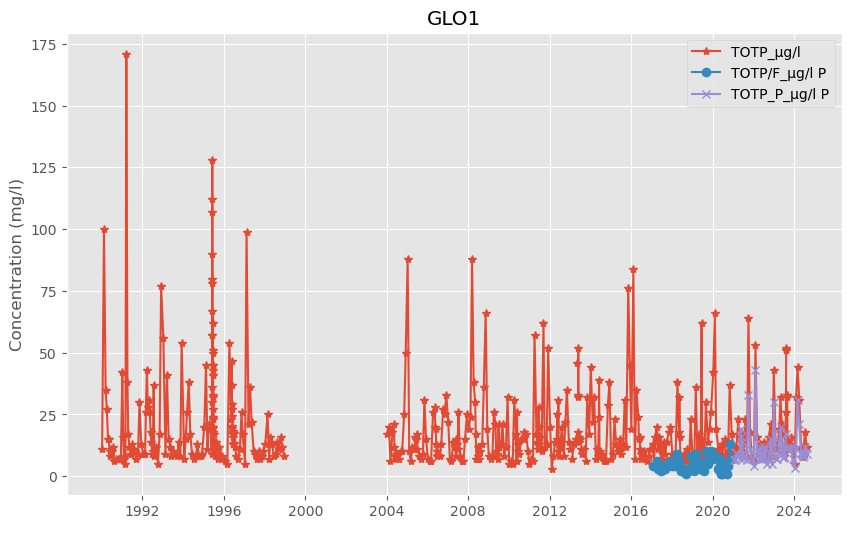

In [12]:
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TOTP_µg/l'], label='TOTP_µg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['TOTP/F_µg/l P'], label='TOTP/F_µg/l P', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOTP_P_µg/l P'], label='TOTP_P_µg/l P', marker='x')

    plt.title(station)
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

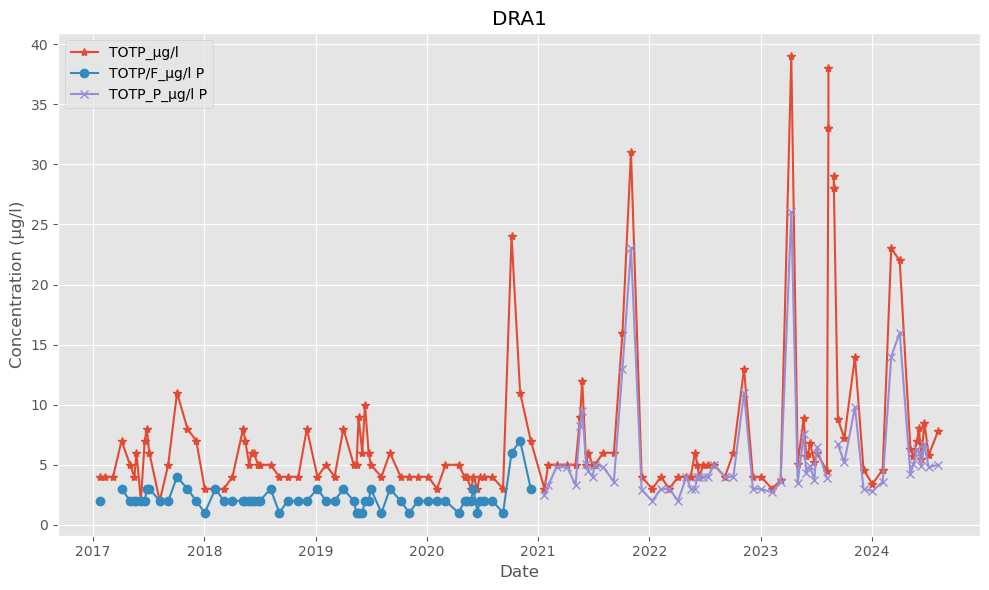

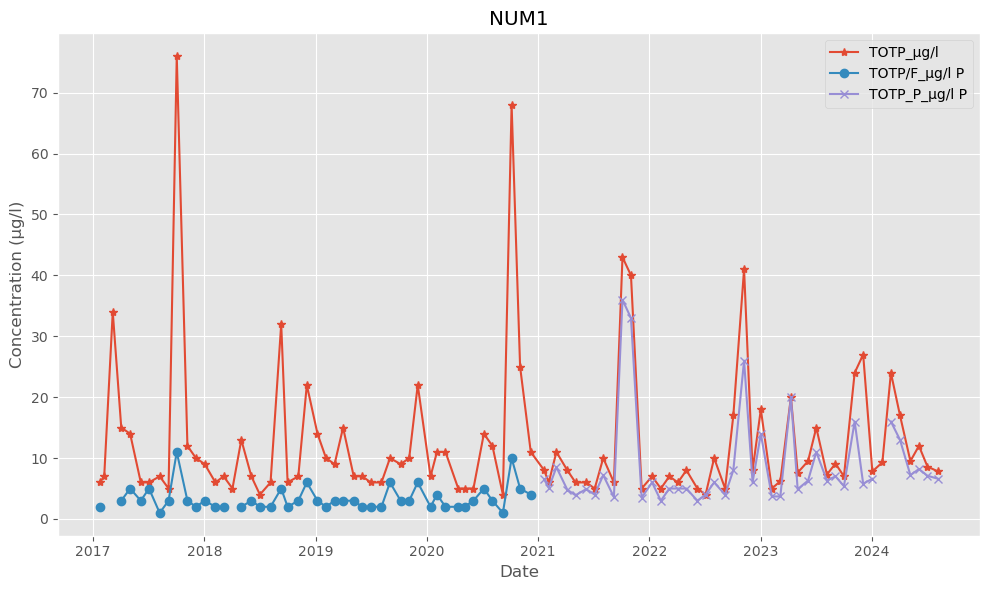

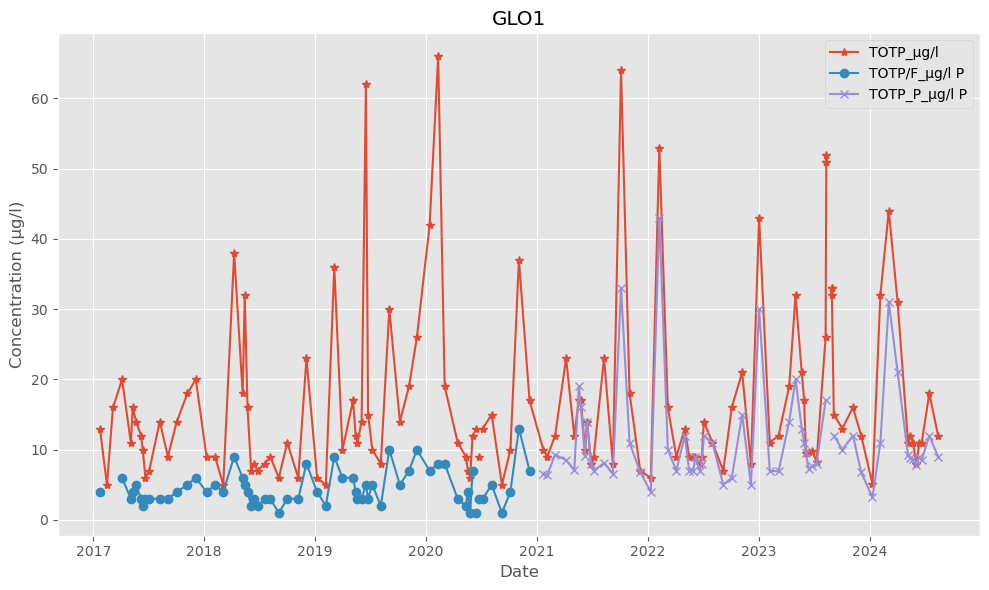

In [13]:
for station in stations:
    # Filter by station and date > 2017
    station_df = wc_df[
        (wc_df['station_code'] == station) &
        (wc_df['sample_date'] >= '2017-01-01')
    ]

    plt.figure(figsize=(10, 6))
    plt.plot(station_df['sample_date'], station_df['TOTP_µg/l'], label='TOTP_µg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['TOTP/F_µg/l P'], label='TOTP/F_µg/l P', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOTP_P_µg/l P'], label='TOTP_P_µg/l P', marker='x')

    plt.title(station)
    plt.xlabel('Date')
    plt.ylabel('Concentration (µg/l)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
wc_df.loc[wc_df['TOTP/F_µg/l P'].isna() & wc_df['TOTP_P_µg/l P'].notna(), 'TOTP/F_µg/l P'] = (
    wc_df['TOTP_µg/l'] - wc_df['TOTP_P_µg/l P']
)

# 3. Then fill the missing particulate fraction (tot_p)
wc_df.loc[wc_df['TOTP_P_µg/l P'].isna() & wc_df['TOTP/F_µg/l P'].notna(), 'TOTP_P_µg/l P'] = (
    wc_df['TOTP_µg/l'] - wc_df['TOTP/F_µg/l P']
)

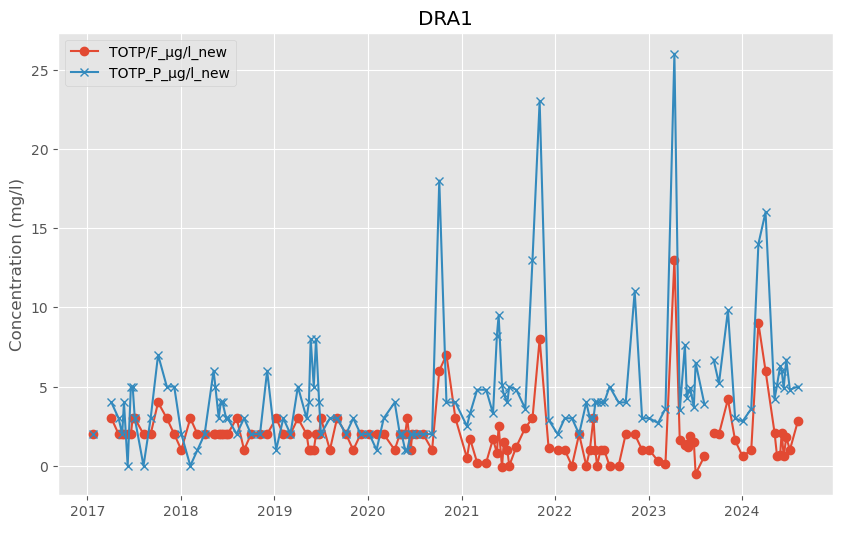

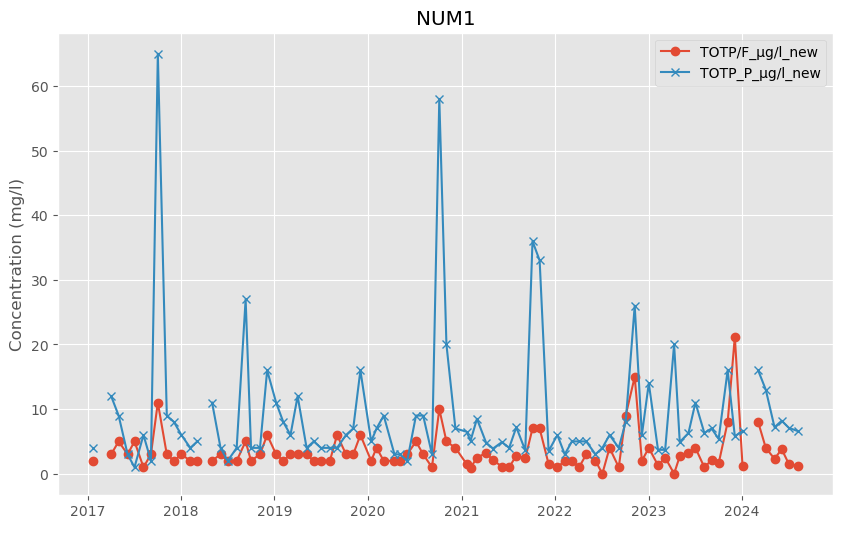

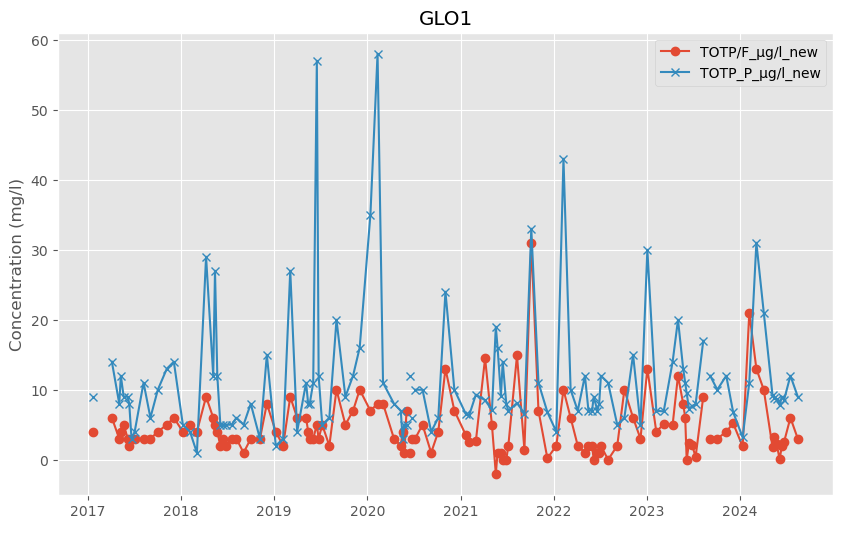

In [15]:
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    # plt.plot(station_df['sample_date'], station_df['TOTP_µg/l'], label='TOTP_µg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['TOTP/F_µg/l P'], label='TOTP/F_µg/l_new', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOTP_P_µg/l P'], label='TOTP_P_µg/l_new', marker='x')

    plt.title(station)
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 3.6 Compare NH4 and NO3

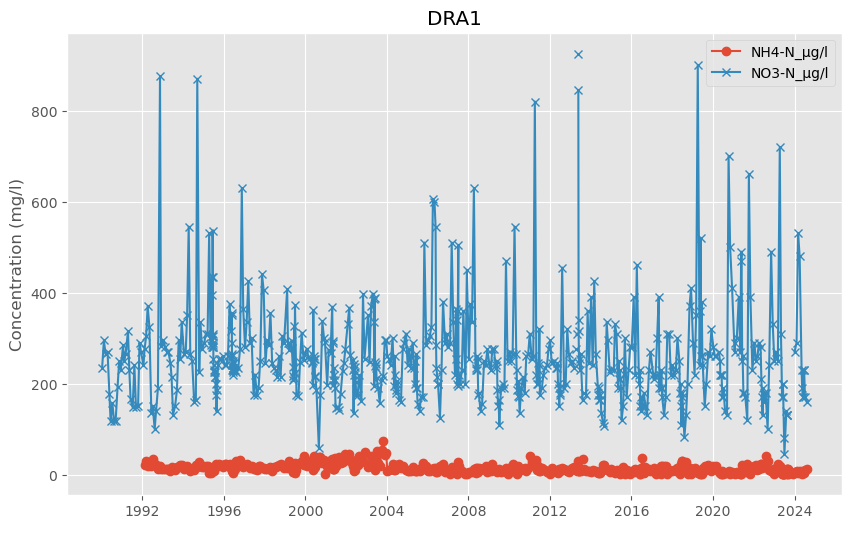

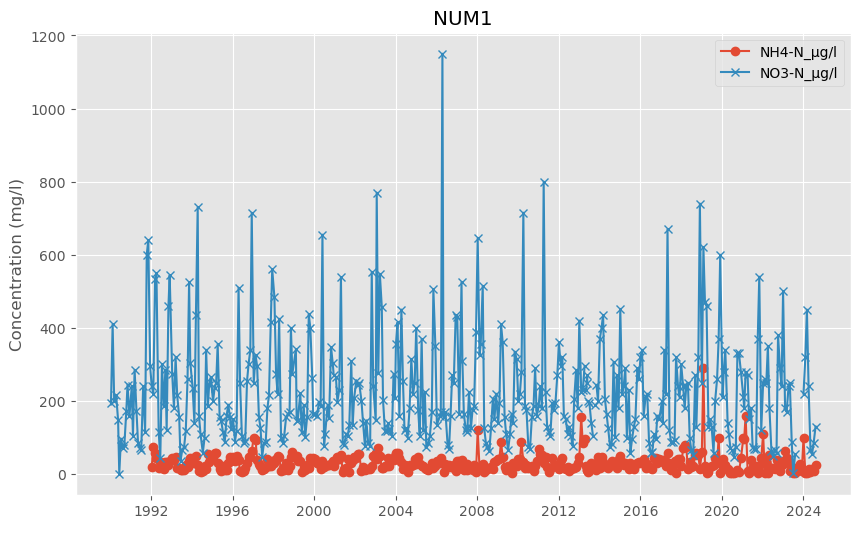

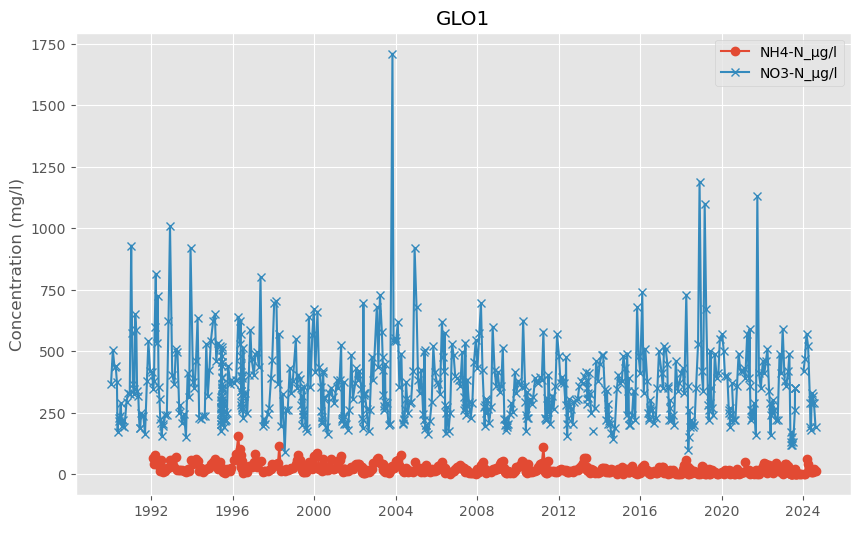

In [16]:
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['NH4-N_µg/l'], label='NH4-N_µg/l', marker='o')
    plt.plot(station_df['sample_date'], station_df['NO3-N_µg/l'], label='NO3-N_µg/l', marker='x')
    
    plt.xlabel(' ')
    plt.title(station)
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Note:** NO3 concentrations are consistently higher than NH4, especially in the Drammenselva and Glomma rivers. A few exceptions exist in the Numedalslågen where NH4 approaches NO3 levels, but overall NH4 << NO3 across all rivers.

#### 3.7 DIN computation

In [17]:
wc_df['DIN_μg/l'] = wc_df['NH4-N_µg/l'] + wc_df['NO3-N_µg/l']  

# Assign outliers: If NO3-N_µg/l is an outlier, mark DIN_μg/l as an outlier too
if 'outlier_NO3-N_µg/l' in wc_df.columns:
    wc_df['outlier_DIN_μg/l'] = wc_df['outlier_NO3-N_µg/l']  # Copy NO3 outliers

#### 3.8 DON computation 

In [18]:
wc_df['DON_µg/l'] = wc_df['TOTN_µg/l'] - wc_df['DIN_μg/l']

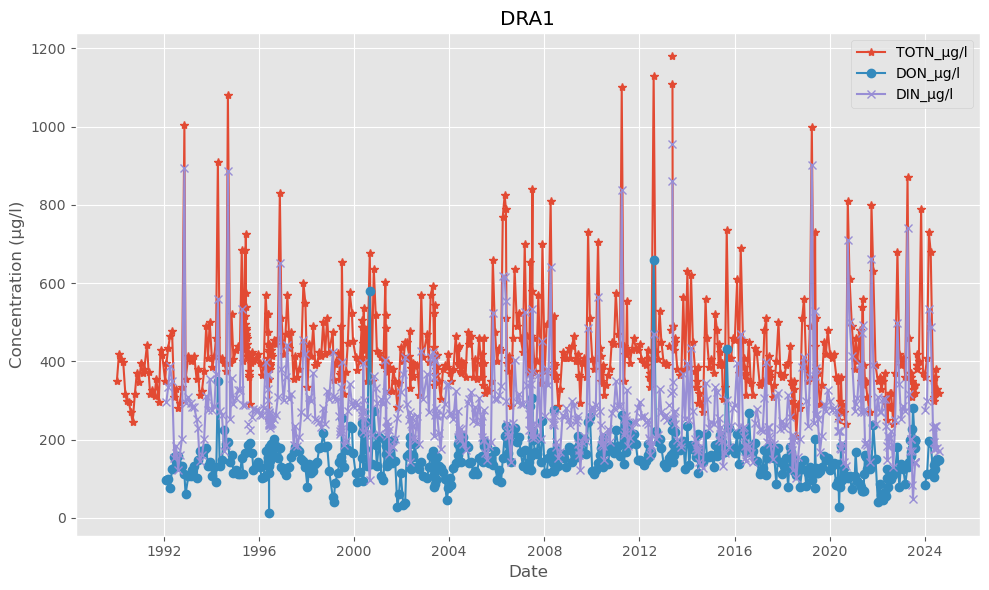

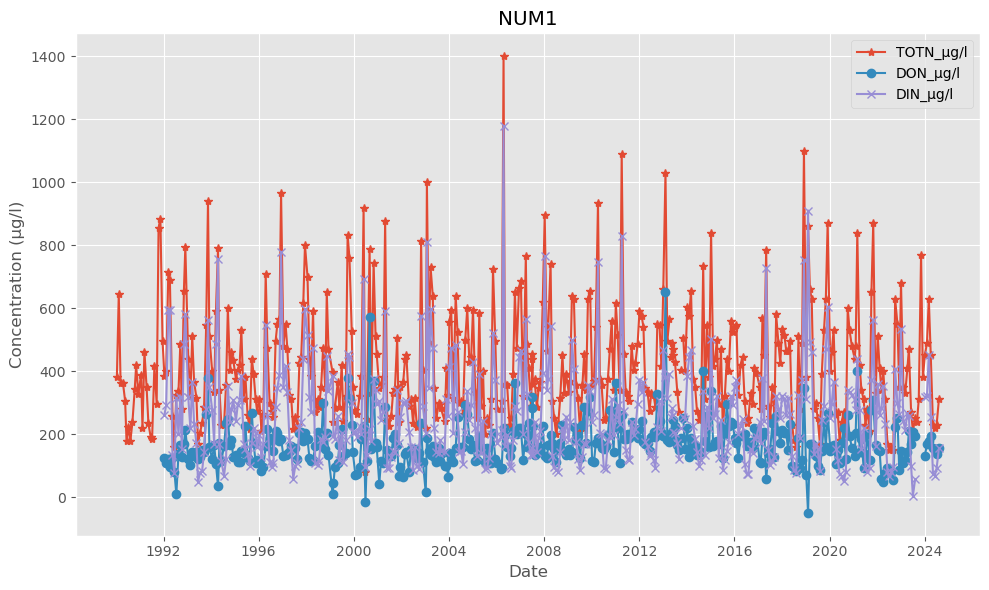

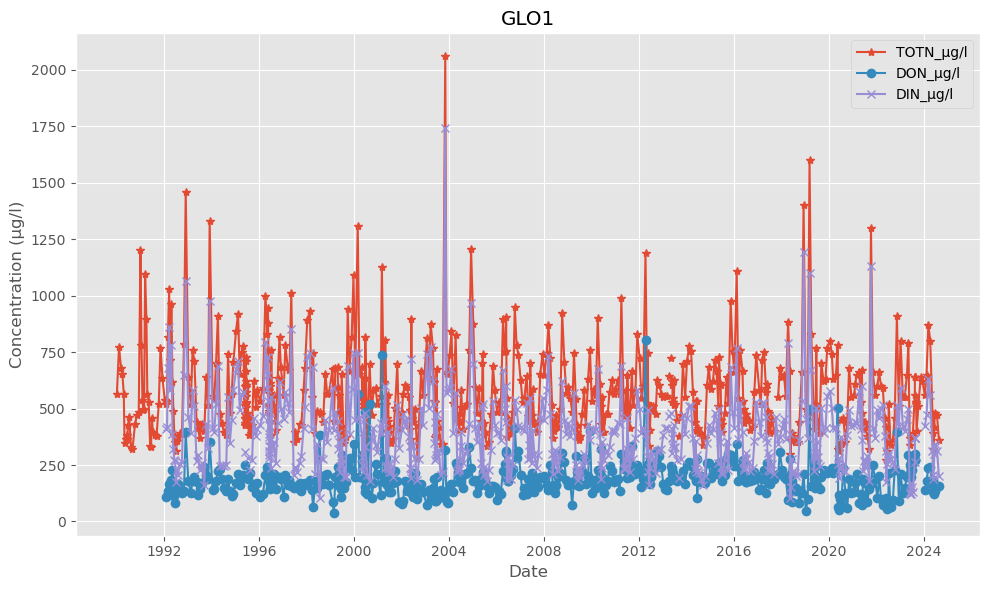

In [19]:
for station in stations:
    # Filter by station and date > 2017
    station_df = wc_df[(wc_df['station_code'] == station)]

    plt.figure(figsize=(10, 6))
    plt.plot(station_df['sample_date'], station_df['TOTN_µg/l'], label='TOTN_µg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['DON_µg/l'], label='DON_µg/l', marker='o')
    plt.plot(station_df['sample_date'], station_df['DIN_μg/l'], label='DIN_μg/l', marker='x')

    plt.title(station)
    plt.xlabel('Date')
    plt.ylabel('Concentration (µg/l)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
# Drop unnecessary columns 
wc_df = wc_df.drop(columns=['DOC/TOC'])

### Plot 

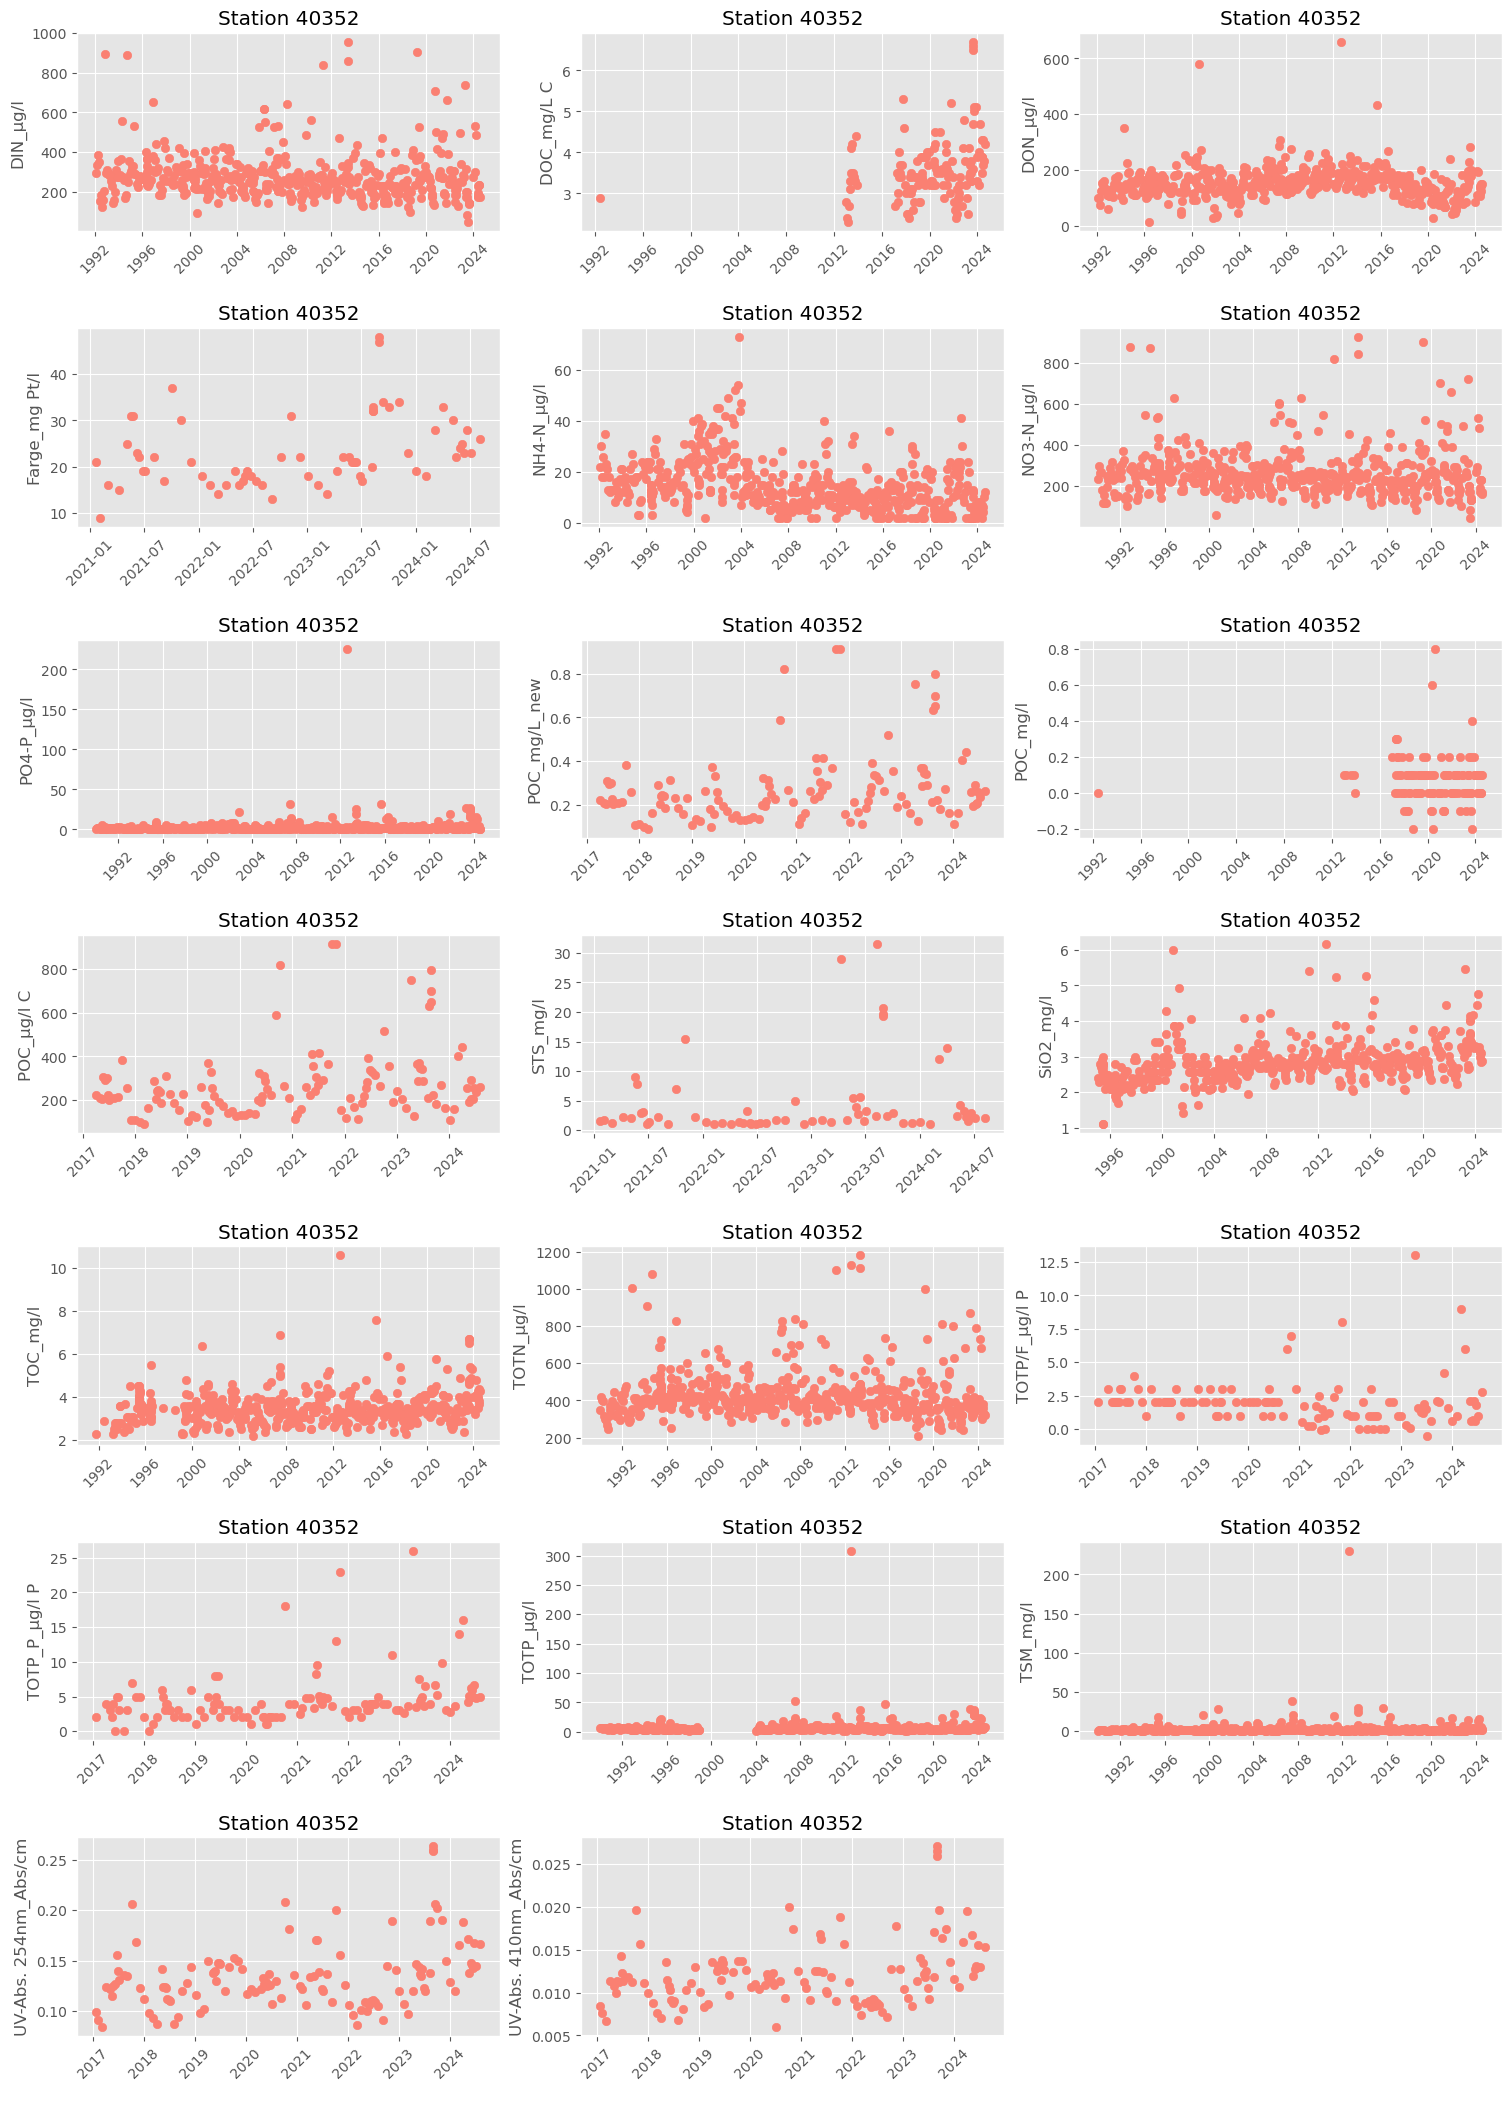

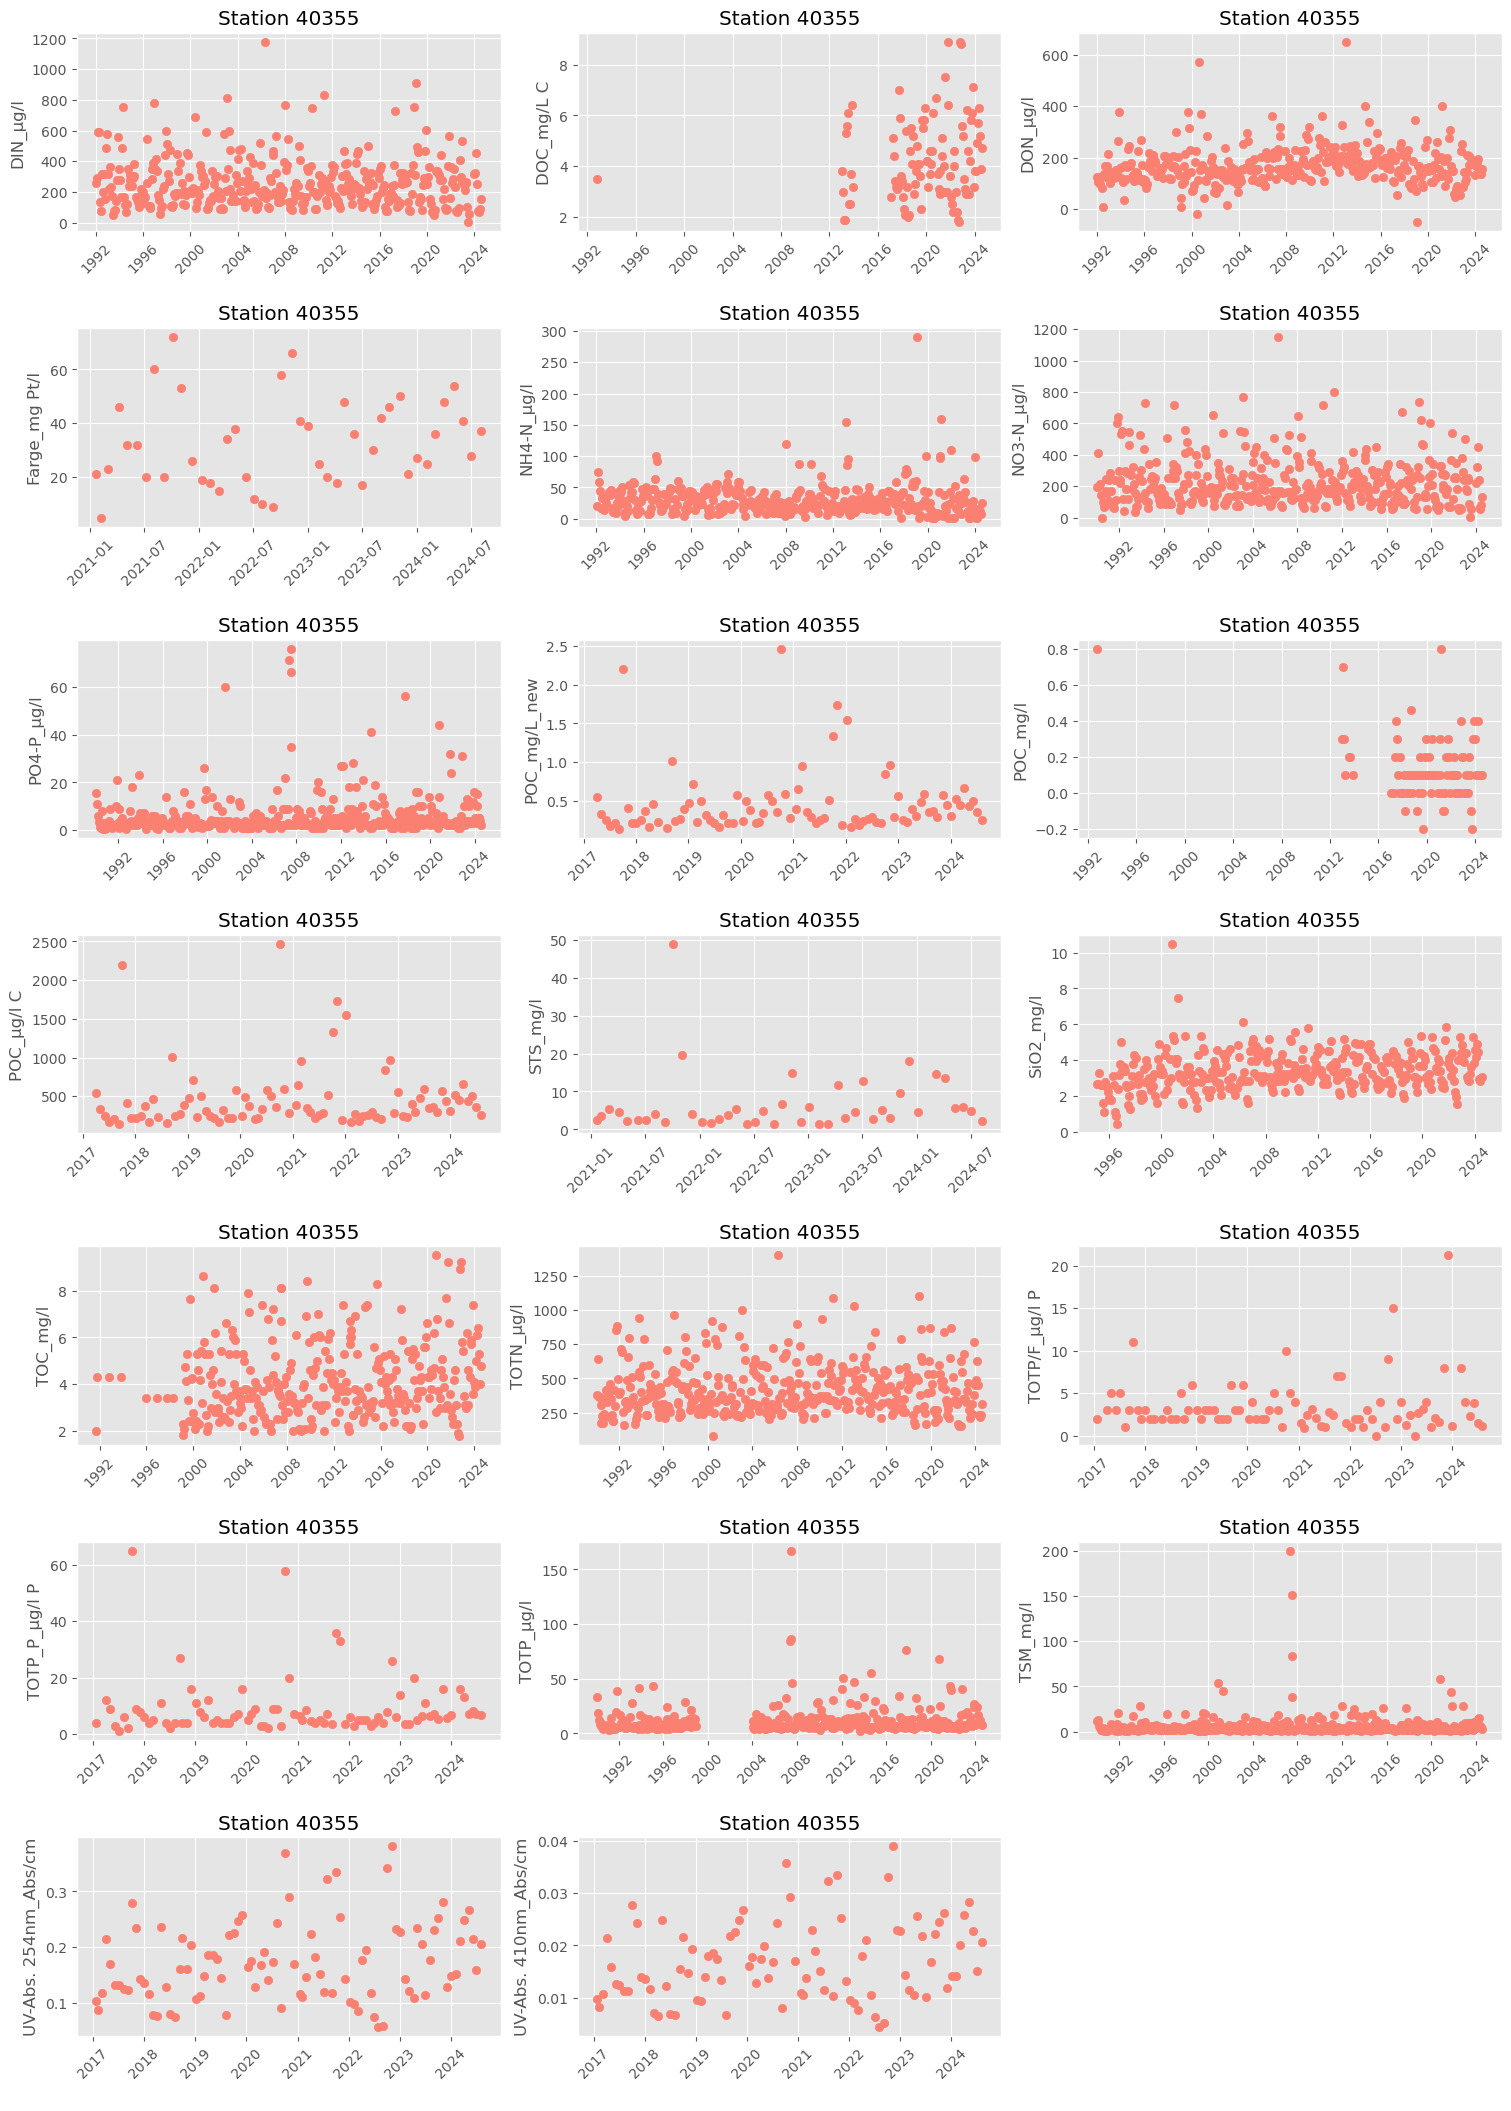

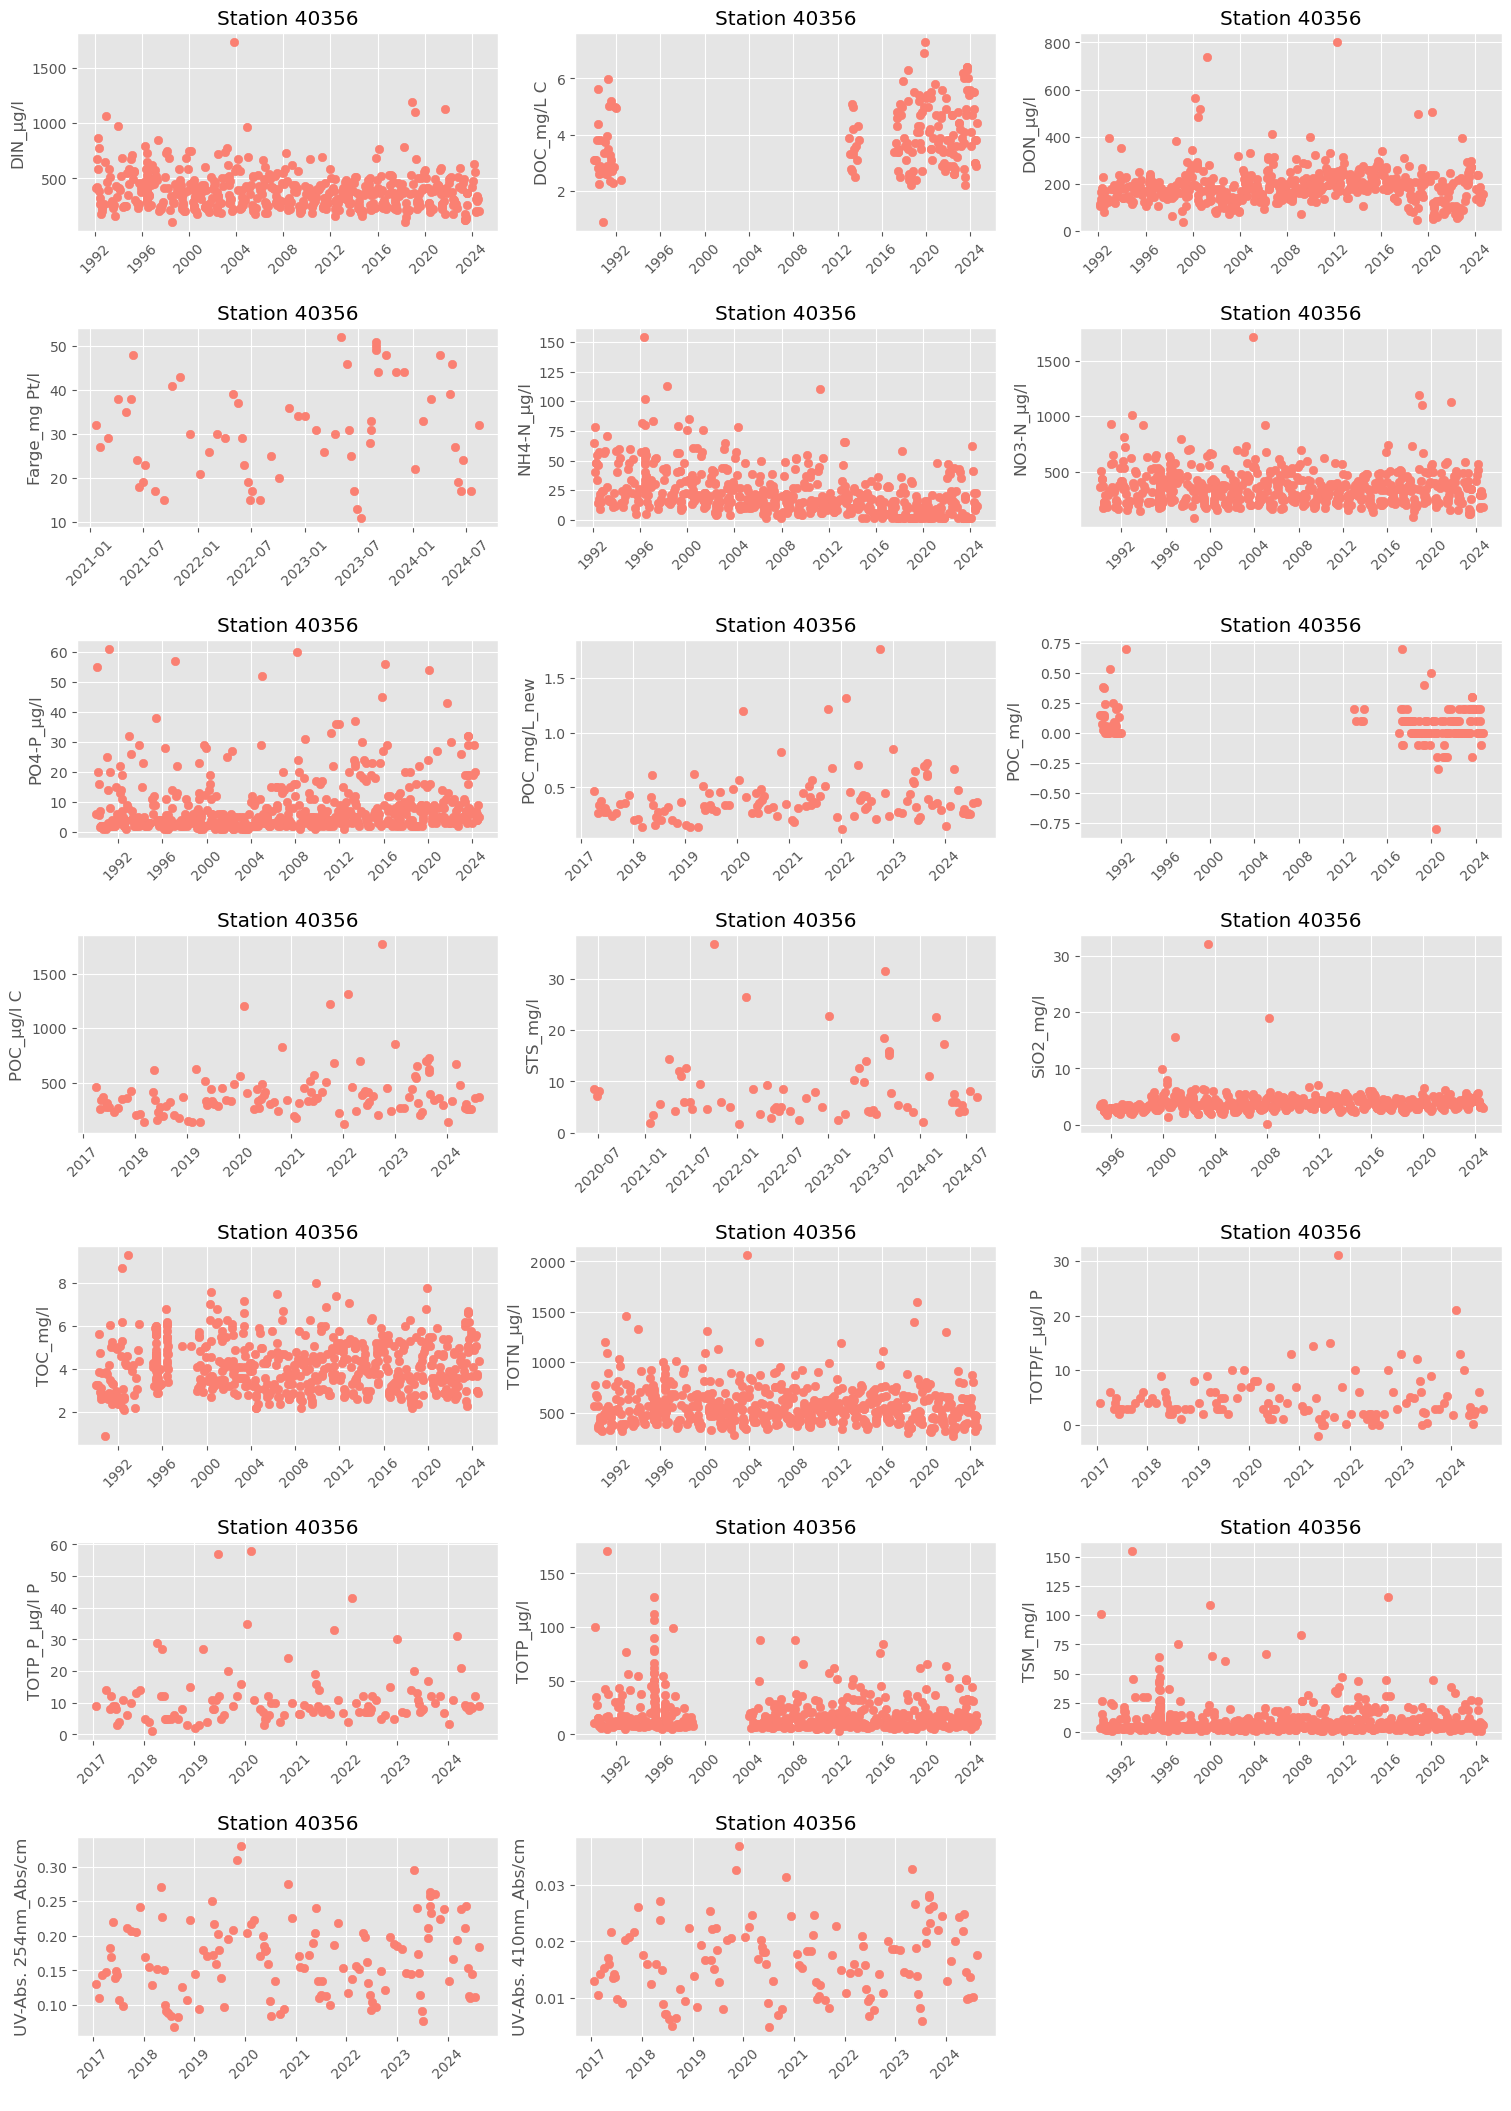

In [21]:
# variables of interest
variables = ['TOC_mg/l', 'DOC_mg/L C', 'POC_mg/l', 'POC_µg/l C', 'POC_mg/L_new',  
             'TOTN_µg/l', 'DIN_µg/l', 'DON_µg/l', 'NH4-N_µg/l', 'NO3-N_µg/l', 
             'TOTP_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'PO4-P_µg/l', 
             'STS_mg/l', 'TSM_mg/l', 
             'SiO2_mg/l', 
             'UV-Abs. 254nm_Abs/cm', 'UV-Abs. 410nm_Abs/cm', 'Farge_mg Pt/l', ]

stations = wc_df["station_id"].unique()

num_cols = 3

# Plot
for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    variables = station_df.columns.difference(["station_id", "station_code", "station_name", "sample_date", "depth1", "depth2"])
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

## 5. Remove outliers manualy 
A quick visual inspection reveals the presence of outliers in the dataset. Some of these have already been flagged using the MAD (Median Absolute Deviation) method as implemented in the `chem1_get_data` notebook, though the method isn't always perfect. Here, outliers are being replaced with NaN values, and the cleaned dataset is saved as a separate file.

In [26]:
condition_map = {
    40352: [
        ('PO4-P_µg/l', 200, '>', np.nan),
        ('TOC_mg/l', 10, '>', np.nan),
        ('TSM_mg/l', 200, '>', np.nan),
        ('TSM_mg/l', 0.7, '<', np.nan),
        ('TOTP_µg/l', 300, '>', np.nan),
        ('TOTP_µg/l', 1.1, '<', np.nan),
        ('SiO2_mg/l', 1.5, '<', np.nan),
        ('DIN_μg/l', 50, '<', np.nan),
        ('Farge_mg Pt/l', 10, '<', np.nan),
    ],
    40355: [
        ('PO4-P_µg/l', 60, '>', np.nan),
        ('SiO2_mg/l', 6.5, '>', np.nan),
        ('SiO2_mg/l', 1, '<', np.nan),
        ('TOTN_µg/l', 1200, '>', np.nan),
        ('TOTN_µg/l', 150, '<', np.nan),
        ('TOTP_P_µg/l P', 30, '>', np.nan),
        ('TSM_mg/l', 50, '>', np.nan),
        ('TSM_mg/l', 0.6, '<', np.nan),
        ('TOTP_µg/l', 150, '>', np.nan),
        ('DIN_μg/l', 5, '<', np.nan),
        ('Farge_mg Pt/l', 6, '<', np.nan),
        ('sample_date', pd.Timestamp('1998-01-01'), '<', 'TOC_mg/l'),
    ],
    40356: [
        ('SiO2_mg/l', 10.5, '>', np.nan),
        ('SiO2_mg/l', 0.1, '<', np.nan),
        ('TOTN_µg/l', 2000, '>', np.nan),
        ('DIN_μg/l', 1500, '>', np.nan),
        ('TOC_mg/l', 1, '<', np.nan),
    ]
}

# Drop outliers based on the condition thresholds 
def apply_conditions(df, station_id, conditions):
    for var, threshold, operator, new_value in conditions:
        if operator == '>':
            condition = (df['station_id'] == station_id) & (df[var] > threshold)
        elif operator == '<':
            condition = (df['station_id'] == station_id) & (df[var] < threshold)
        elif operator == '=':
            condition = (df['station_id'] == station_id) & (df[var] == threshold)
        else:
            continue
        
        if var == 'sample_date' and new_value == 'TOC_mg/l':
            df.loc[(df['station_id'] == station_id) & (df['sample_date'] < threshold), 'TOC_mg/l'] = np.nan    # Only replace TOC_mg/l values before the threshold date
        else:
            df.loc[condition, var] = new_value
    return df

for station_id, conditions in condition_map.items():
    wc_df = apply_conditions(wc_df, station_id, conditions)

In [27]:
# Filter out 'TOTP_P' values before 08-2022 for 'Numedalslågen v/E18' river
wc_df.loc[(wc_df["station_id"]==40355) & (wc_df["sample_date"]<pd.Timestamp('2022-09-01')), 'TOTP_P_µg/l P']=np.nan

### 4. Parameters visualization

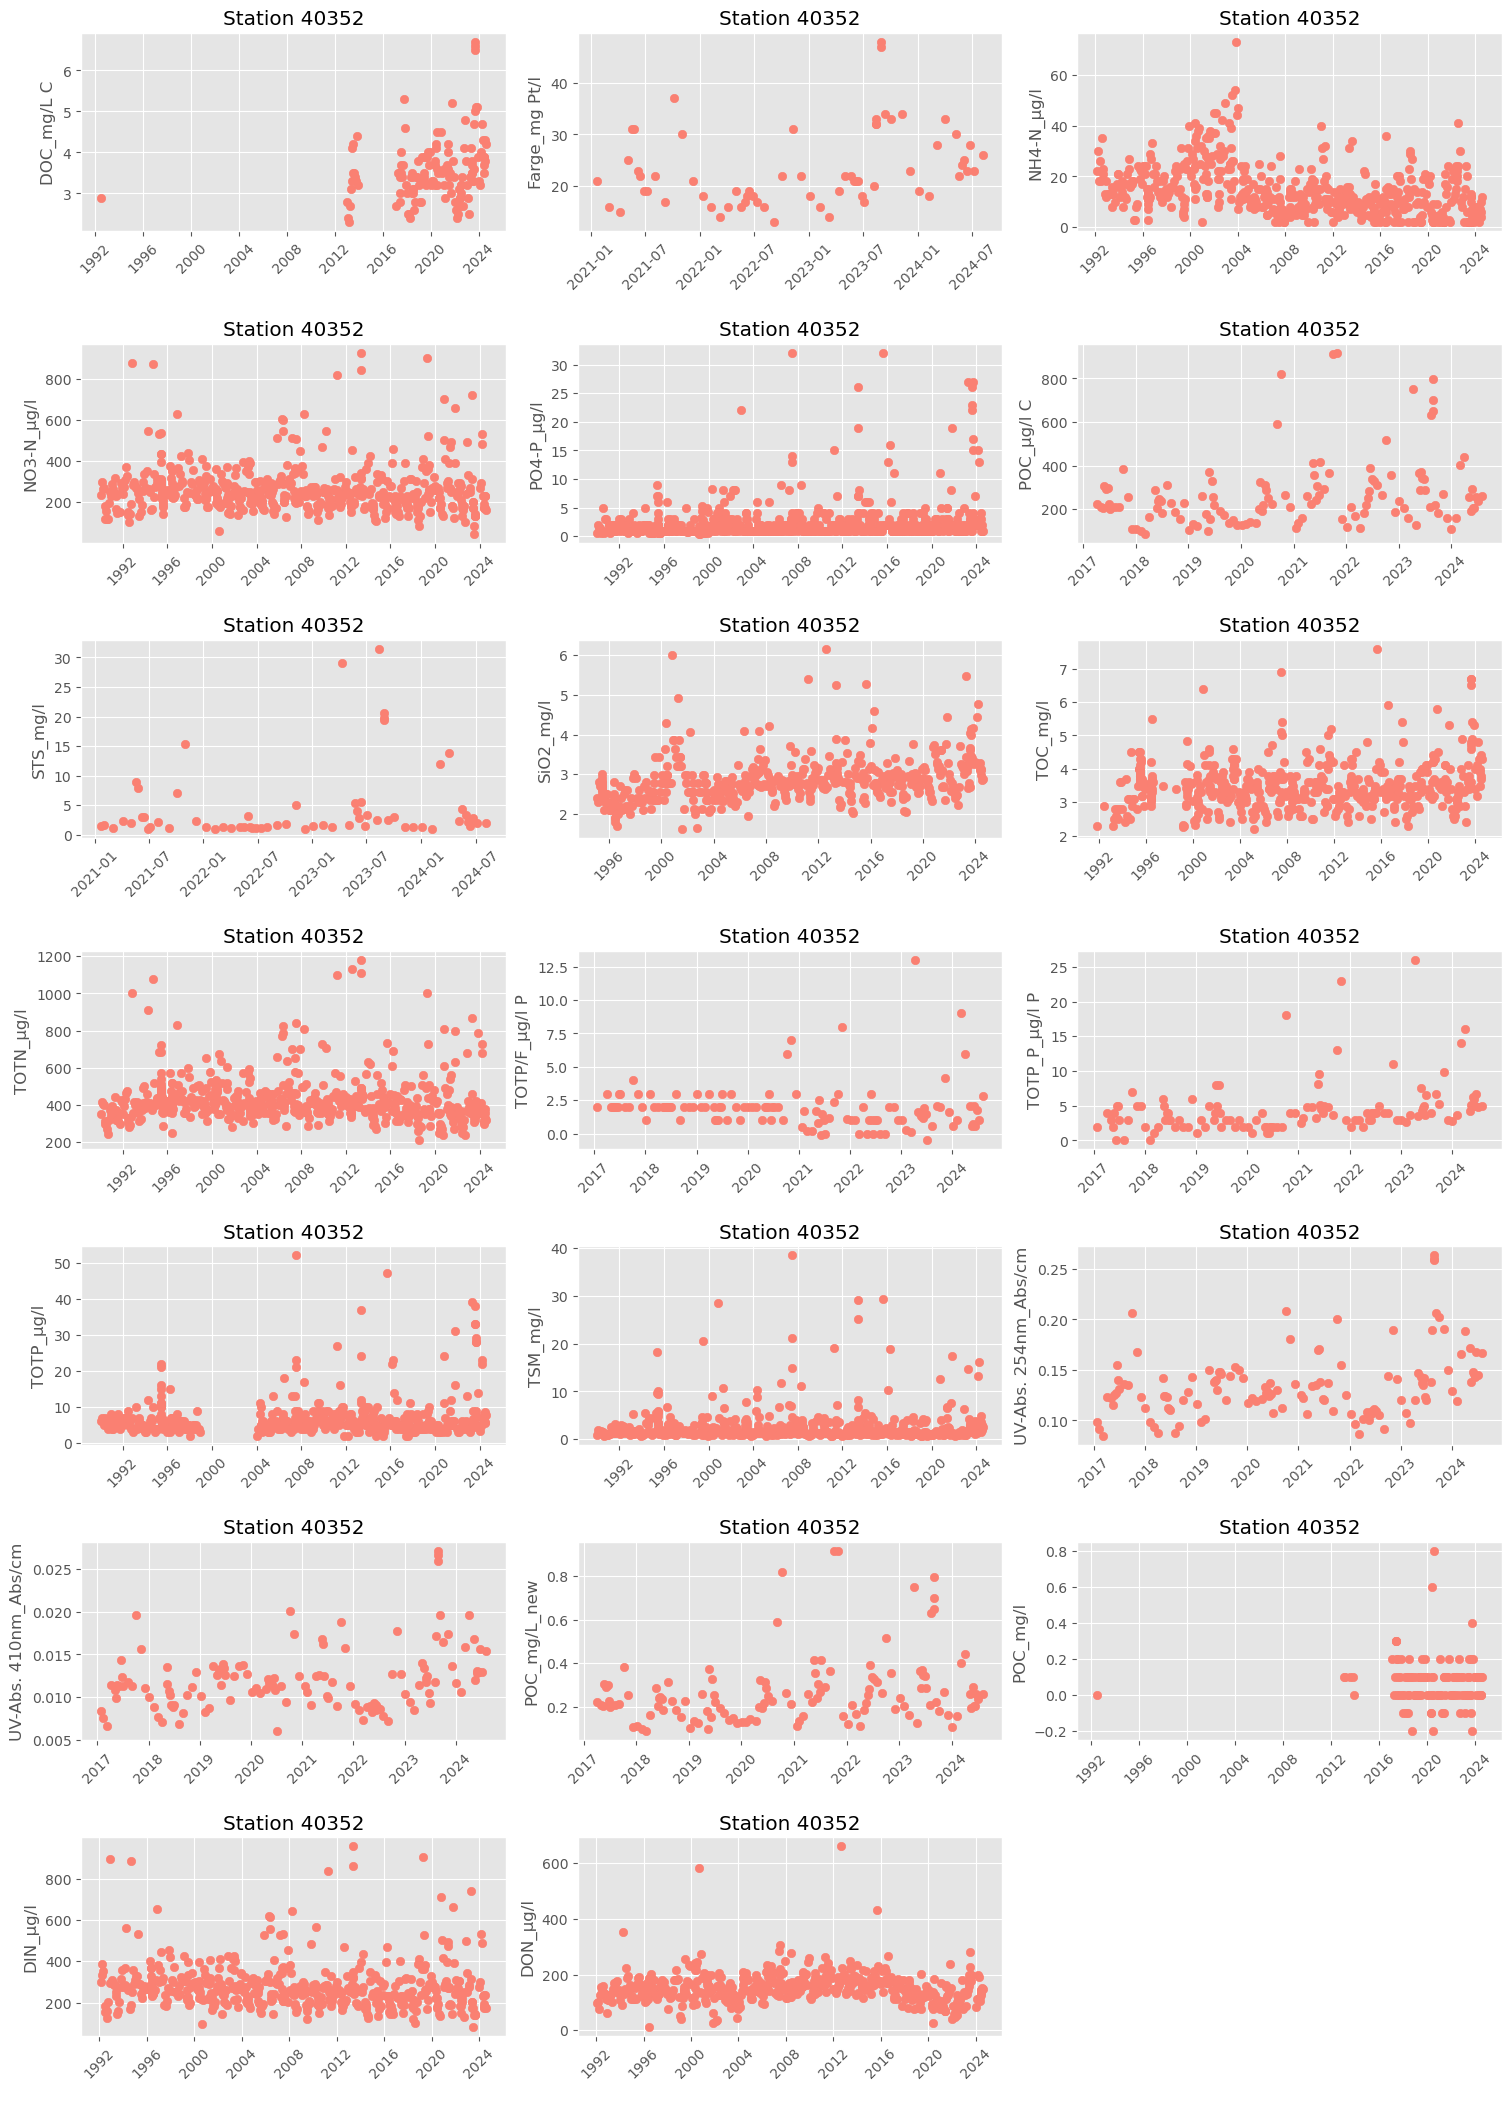

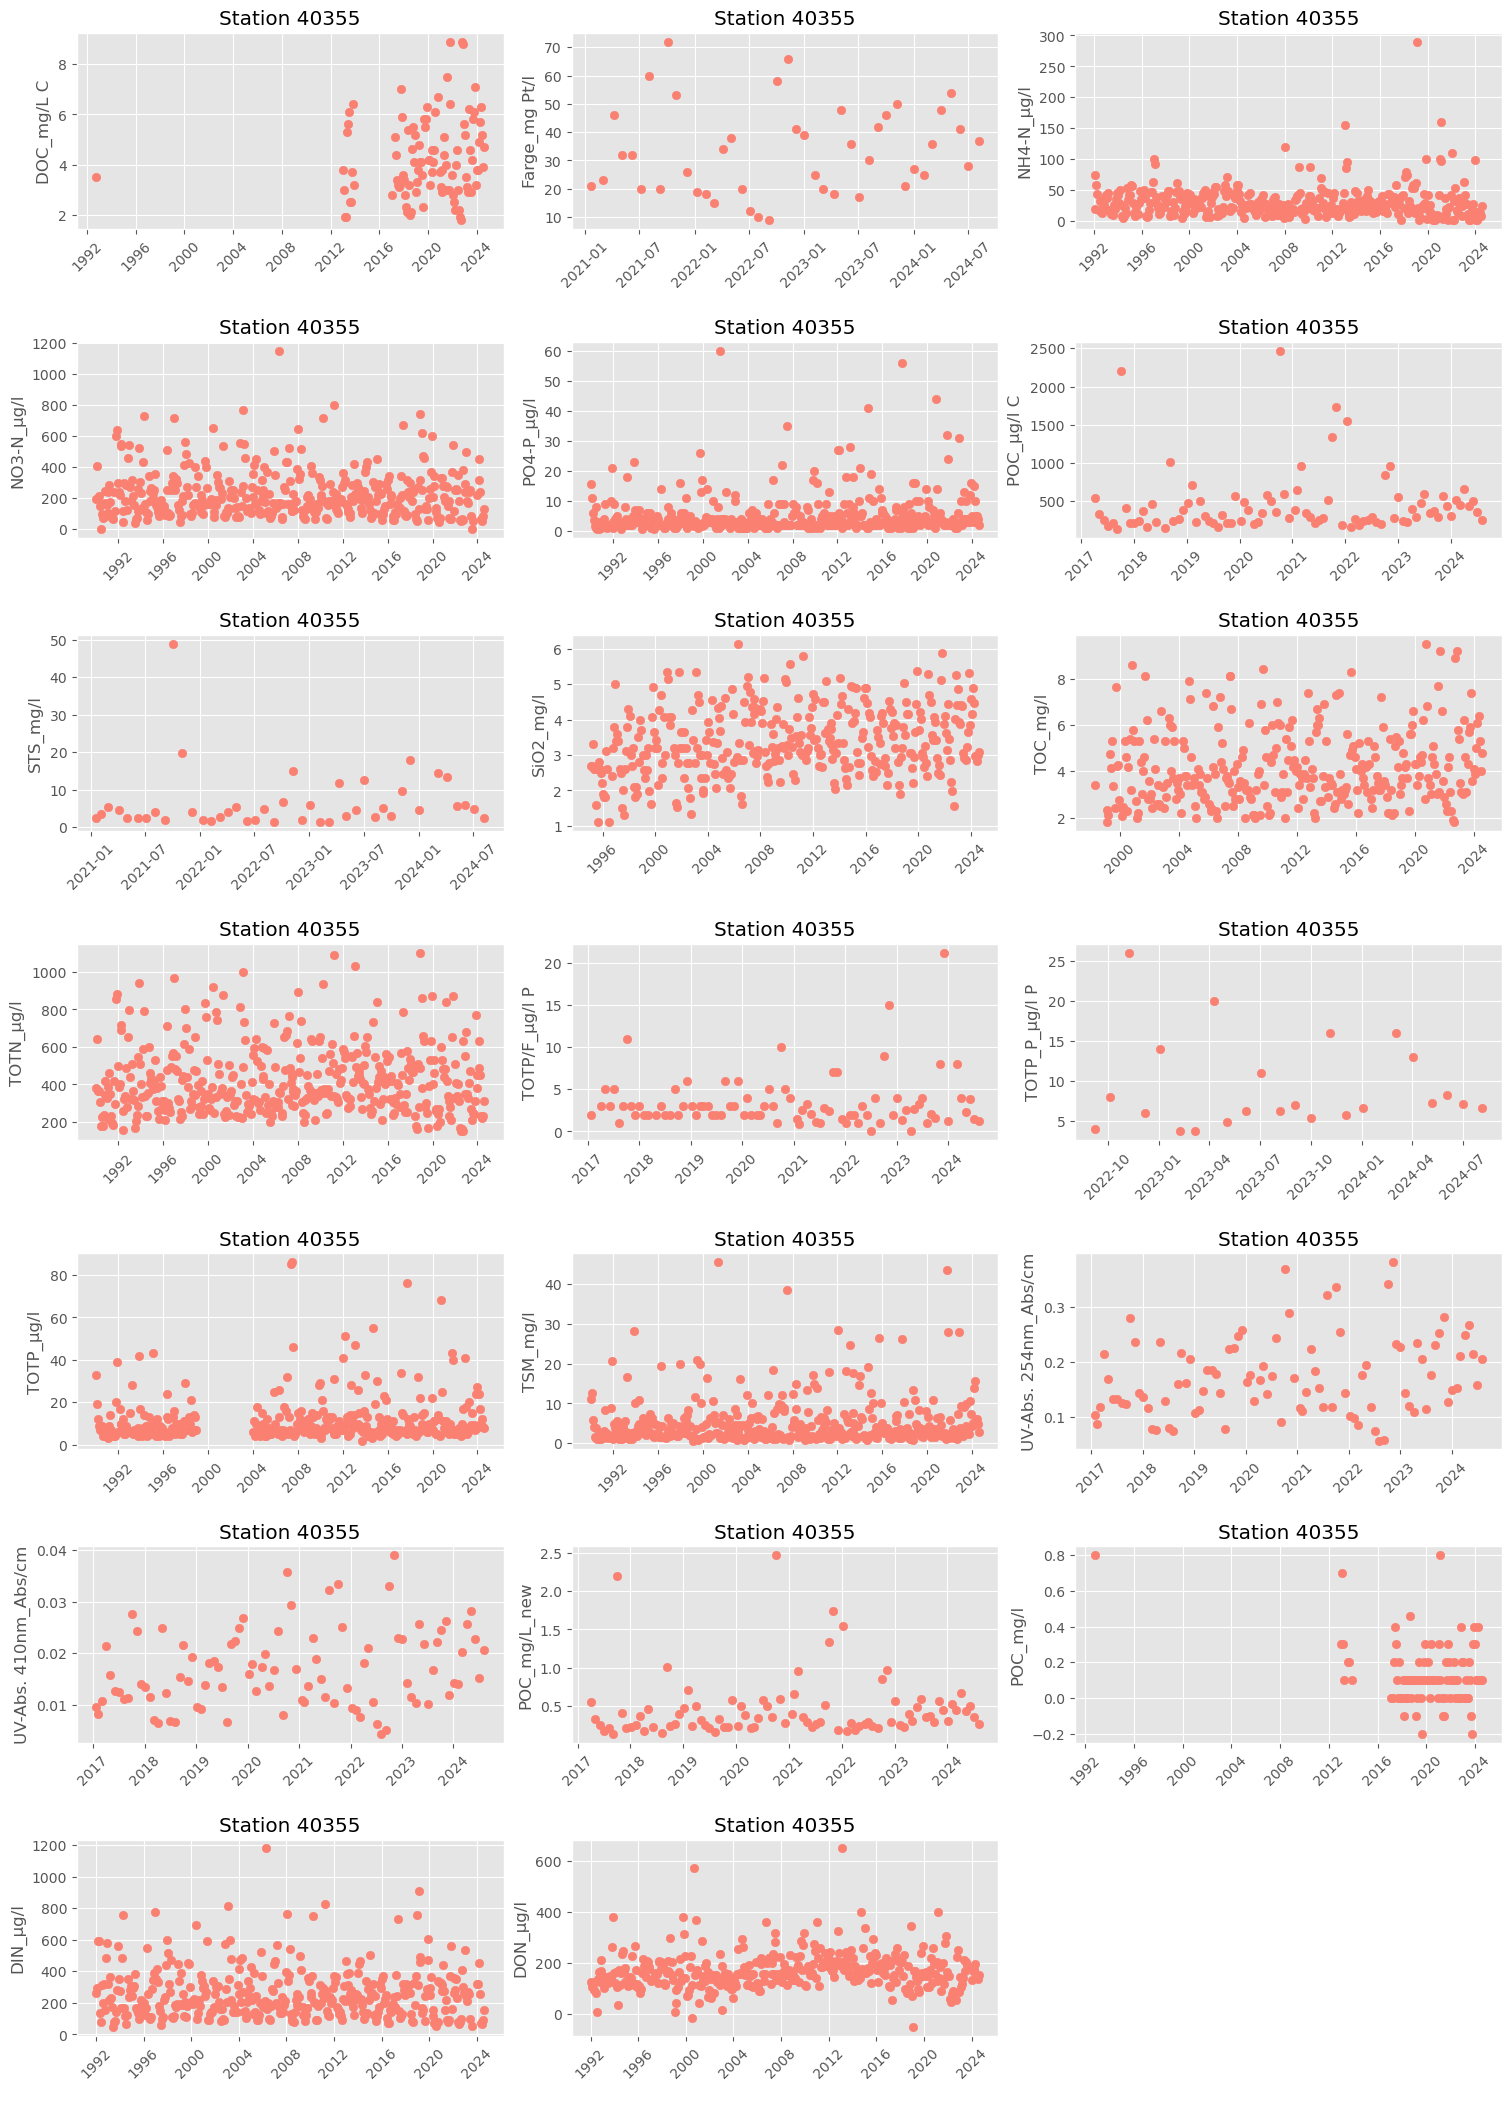

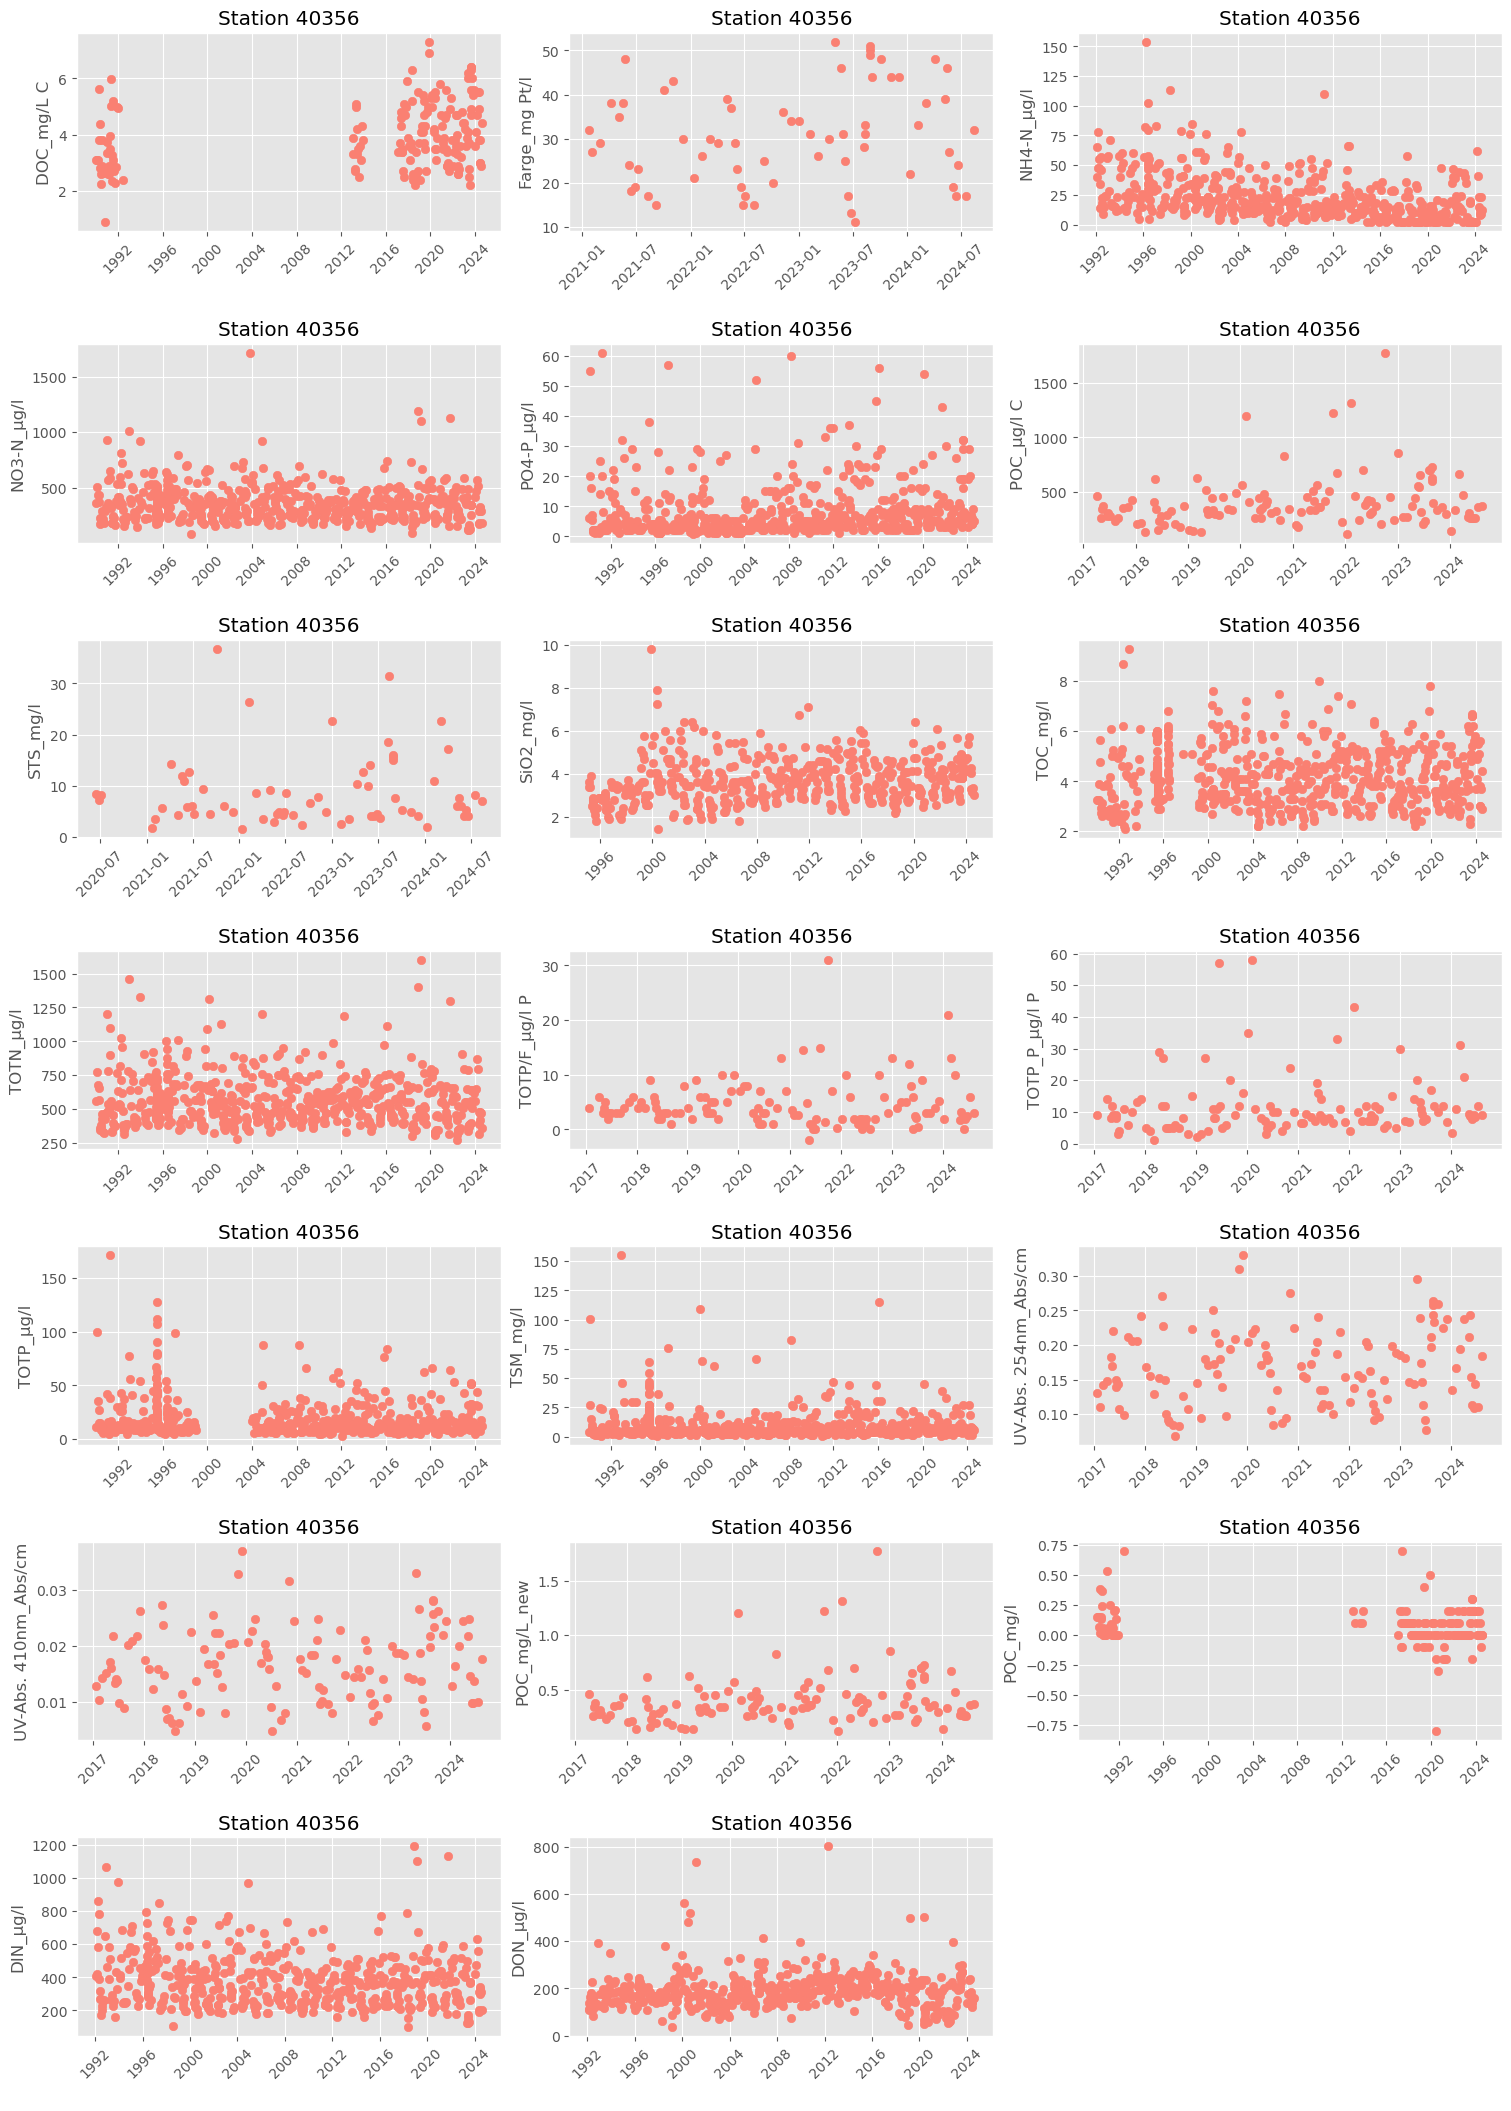

In [28]:
stations = wc_df["station_id"].unique()

num_cols = 3

processed_variables = [col for col in wc_df.columns if col not in ["station_id", "station_code", "station_name", "sample_date"]]

for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    
    num_rows = (len(processed_variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    axes = axes.flatten()
    
    for i, var in enumerate(processed_variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
       
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [29]:
wc_df.to_csv(output_path, index=False)